<a href="https://colab.research.google.com/github/eedanileiko/Data-Analytics-Portfolio/blob/main/Features_prediction_ml_projectdanileyko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение, ФКН ВШЭ

##Генерация признаков

### О задании

В данном задании я реализую самые ходовые техники для создания новых признаков в табличном машинном обучении.\
Цель-получить самую точную модель.


### Вводная часть
    
В этом домашнем задании мы будем работать с датасетом видеоигре Dota 2.

Подробное описание данных настолько большое, что описано отдельно на страничке соревнования.

Очень краткое описание игры:
- Dota 2 - это командная игра, в которой принимает участие 5 игроков со стороны Radiant и 5 игроков со стороны Dire;
- каждый из игроков выбирает своего героя, все герои в одной игре разные, у каждого героя есть ряд атрибутов, которые сильно отличают его от других;
- цель игроков - снести главную постройку вражеской стороны (в простонародье - трон);
- игроки могут зарабатывать деньги, убивать персонажей вражеской команды, чтобы становиться сильнее и легче снести этот самый трон;
- игра всегда заканчивается победой одной стороны, может идти от 0 минут до бесконечности.

Мы будем пытаться предсказать исход матча - победа или поражение, исходя из разных факторов, с которыми мы познакомимлся ниже. По задумке мы пытаемся предсказать матчи, которые едва начались (например, чтобы делать ставки на спорт), поэтому ряд данных на тестовой выборке отсутствует. Целевая метрика уже выбрана за нас: мы будем считать ROC-AUC, но не простой, а коэффициент Джини, чтобы избегать странных значений метрики меньше $0.5$:

$$ \text{Gini} = | 2 \cdot \text{ROCAUC} - 1 |$$

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.metrics import roc_auc_score
from typing import Optional, Callable


def gini(y_true, y_score):
    return abs(2 * roc_auc_score(y_true, y_score) - 1.0)

####Знакомство с данными

Чтобы начать работу с данными, эти данные сперва нужно загрузить. В рамках этого ноутбука нам потребуются:

1. Информация о матчах - `matches_df_train.csv`.
2. Информация об игроках - `player_df.csv`.
3. Информация о героях - `Constants.Heroes.csv`.
4. Информация о статистиках матча - `dota_adv.csv`.
5. Тестовые данные для соревнования - `matches_df_test.csv`.


In [ ]:
#откроем все файлы
matches_df_train=pd.read_csv('matches_df_train.csv')
player_df=pd.read_csv('player_df.csv')
Heroes=pd.read_csv('Constants.Heroes.csv')
dota_ad=pd.read_csv('dota_adv.csv')
matches_df_test=pd.read_csv('matches_df_test.csv')

**matches_df_train.csv - тренировочные данные матчей:**

1) match_id - айди матча <font color='blue'>понадобится для джоина таблиц</font>.
2) date - дата, когда был сыгран матч  <font color='blue'>скорее всего бесполезный признак</font>.
3) region - регион, где был проведен матч
4) game_mode - режим матча, в игре их доступно несколько
5) duration - длительность матча
6) radiant_win - победа команды сил Света <font color='blue'>наша целевая переменная</font>.

In [ ]:
matches_df_train.head()

,match_id,date,region,game_mode,duration,radiant_win
0,1606558457,2024-01-01,3,1,50,True
1,1533104773,2024-01-01,3,1,86,True
2,1494396881,2024-01-01,3,1,211,True
3,1457581060,2024-01-01,3,1,270,True
4,1590242915,2024-01-01,3,21,318,True


In [ ]:
matches_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706880 entries, 0 to 706879
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   match_id     706880 non-null  int64 
 1   date         706880 non-null  object
 2   region       706880 non-null  int64 
 3   game_mode    706880 non-null  int64 
 4   duration     706880 non-null  int64 
 5   radiant_win  706880 non-null  bool  
dtypes: bool(1), int64(4), object(1)
memory usage: 27.6+ MB


<font color='blue'>Посмотрим, что с пропусками в таблице в количественном ипроцентном выражении</font>.

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #для более удобного анализа сделаем таблицу с процентом от
        # сделаем таблицу с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        return mis_val_table

In [ ]:
missing_values_table(matches_df_train)

,0,1
match_id,0,0.0
date,0,0.0
region,0,0.0
game_mode,0,0.0
duration,0,0.0
radiant_win,0,0.0


<font color='blue'>Теперь посмотрим, что с выбросами данных</font>.

In [ ]:
def outliers(df):
    num=df.select_dtypes([np.number])
    df_table=pd.Series()
    for i in num:
        Q1 = np.quantile(df[i], 0.25)
        Q3 = np.quantile(df[i], 0.75)
        IQR = Q3 - Q1
        # Определяем границы для выбросов
        upper_outlier_threshold = Q3 + 1.5 * IQR
        lower_outlier_threshold = Q1 - 1.5 * IQR
        upper = df[i][df[i]> upper_outlier_threshold].count()
        lower= df[i][df[i] < lower_outlier_threshold].count()
        df_table[i]=upper+lower
    return df_table


In [ ]:
outliers(matches_df_train)

match_id         35
region       163376
game_mode         0
duration      16511
dtype: int64

<font color='blue'>не то что бы нам тут выбросы нам о чем-то нужном говорят</font>.

<font color='blue'>Теперь посмотрим на распределние целевой переменной.</font>

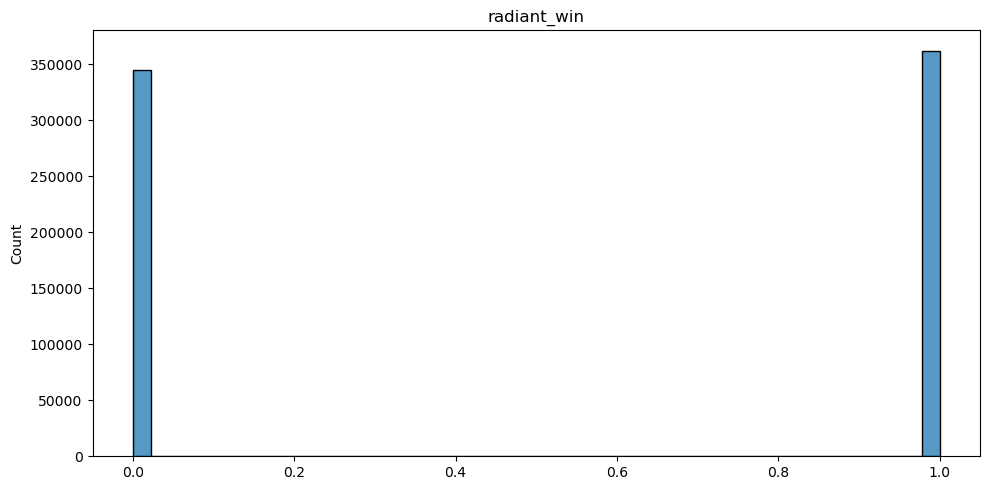

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(np.array(matches_df_train['radiant_win']), label='radiant_win')
plt.title('radiant_win')
plt.tight_layout()
plt.show()

<font color='blue'>Примерно равное количество побед и проигрышей.</font>

**matches_df_test.csv - тестовые данные матчей:**

1) match_id - айди матча (деанонимизирован, можете даже не пытаться) <font color='blue'>все еще для джоина</font>
2) date - дата, когда был сыгран матч
3) region - регион, где был проведен матч
4) game_mode - режим матча, в игре их доступно несколько

In [ ]:
player_df.head()

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
0,130,10111871,5,3.0,8.0,15.0,2971.0,55.0,3.0,291.0,390.0,7431.0,146.0,1411590681
1,130,43341844,3,3.0,9.0,3.0,1245.0,25.0,3.0,238.0,346.0,4187.0,34.0,1388958799
2,130,72157343,53,9.0,6.0,20.0,4544.0,226.0,1.0,583.0,704.0,9406.0,2375.0,1587246664
3,1,4294967295,17,21.0,3.0,15.0,2945.0,209.0,12.0,577.0,641.0,30957.0,1801.0,1490278157
4,2,54350942,19,9.0,8.0,8.0,413.0,227.0,9.0,471.0,584.0,18215.0,627.0,1526223166


In [ ]:
player_df.describe()

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
count,7.650825e+06,7.650825e+06,7.650825e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.650825e+06
mean,6.599817e+01,1.631673e+09,4.937297e+01,7.303896e+00,7.630180e+00,1.123294e+01,1.812635e+03,1.265898e+02,4.823221e+00,3.954036e+02,4.502470e+02,1.177186e+04,1.216333e+03,1.482980e+09
std,6.401565e+01,2.021473e+09,3.287511e+01,5.630179e+00,3.957078e+00,6.527763e+00,1.720842e+03,9.653540e+01,5.750519e+00,1.328248e+02,1.488304e+02,6.865572e+03,1.690460e+03,1.113191e+08
min,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.454135e+08
25%,2.000000e+00,8.294824e+07,2.000000e+01,3.000000e+00,5.000000e+00,6.000000e+00,5.580000e+02,5.500000e+01,1.000000e+00,3.000000e+02,3.450000e+02,6.771000e+03,1.050000e+02,1.393629e+09
50%,4.000000e+00,1.371006e+08,4.400000e+01,6.000000e+00,7.000000e+00,1.000000e+01,1.288000e+03,1.040000e+02,3.000000e+00,3.790000e+02,4.460000e+02,1.049700e+04,5.260000e+02,1.498887e+09
75%,1.300000e+02,4.294967e+09,7.700000e+01,1.000000e+01,1.000000e+01,1.500000e+01,2.593000e+03,1.730000e+02,7.000000e+00,4.750000e+02,5.500000e+02,1.546400e+04,1.607000e+03,1.588701e+09
max,1.320000e+02,4.294967e+09,1.120000e+02,1.280000e+02,7.800000e+01,1.280000e+02,6.540500e+04,2.000000e+03,2.230000e+02,2.500000e+03,2.500000e+03,1.000000e+05,3.247700e+04,1.636028e+09


In [ ]:
missing_values_table(player_df)

,0,1
player_slot,0,0.000000
account_id,0,0.000000
hero_id,0,0.000000
kills,607494,7.940242
deaths,607494,7.940242
assists,607494,7.940242
gold,607494,7.940242
last_hits,607494,7.940242
denies,607494,7.940242
gold_per_min,607494,7.940242


In [ ]:
outliers(player_df)

player_slot       0
account_id        0
hero_id           0
kills             0
deaths            0
assists           0
gold              0
last_hits         0
denies            0
gold_per_min      0
xp_per_min        0
hero_damage       0
tower_damage      0
match_id        383
dtype: int64

**player_df.csv - данные игроков, участвовавших в матче:**

1) player_slot - слот, который занял игрок, всего их 10 в каждом матче, принимает значение 0-4 и 128-132
2) account_id - аккаунт игрока
3) hero_id - герой, на котором играл игрок
4) kills - количество убийств, которое совершил игрок
5) deaths - количество смертей игрока
6) assists - количество ассистов (в игре), которые сделал игрок
7) gold - сколько золота заработал игрок
8) last_hits - сколько вражеских крипов добил игрок
9) denies - сколько союзных крипов добил игрок
10) gold_per_min - сколько золота в минуту зарабатывал игрок в течение матча
11) xp_per_min - сколько опыта в минуту зарабатывал игрок в течение матча
12) hero_damage - урон, который игрок нанес по другим героям
13) tower_damage - урон, который игрок нанес по вражеским постройкам
14) match_id - айди матча

In [ ]:
player_df.head()

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
0,130,10111871,5,3.0,8.0,15.0,2971.0,55.0,3.0,291.0,390.0,7431.0,146.0,1411590681
1,130,43341844,3,3.0,9.0,3.0,1245.0,25.0,3.0,238.0,346.0,4187.0,34.0,1388958799
2,130,72157343,53,9.0,6.0,20.0,4544.0,226.0,1.0,583.0,704.0,9406.0,2375.0,1587246664
3,1,4294967295,17,21.0,3.0,15.0,2945.0,209.0,12.0,577.0,641.0,30957.0,1801.0,1490278157
4,2,54350942,19,9.0,8.0,8.0,413.0,227.0,9.0,471.0,584.0,18215.0,627.0,1526223166


In [ ]:
player_df.describe()

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
count,7.650825e+06,7.650825e+06,7.650825e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.043331e+06,7.650825e+06
mean,6.599817e+01,1.631673e+09,4.937297e+01,7.303896e+00,7.630180e+00,1.123294e+01,1.812635e+03,1.265898e+02,4.823221e+00,3.954036e+02,4.502470e+02,1.177186e+04,1.216333e+03,1.482980e+09
std,6.401565e+01,2.021473e+09,3.287511e+01,5.630179e+00,3.957078e+00,6.527763e+00,1.720842e+03,9.653540e+01,5.750519e+00,1.328248e+02,1.488304e+02,6.865572e+03,1.690460e+03,1.113191e+08
min,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.454135e+08
25%,2.000000e+00,8.294824e+07,2.000000e+01,3.000000e+00,5.000000e+00,6.000000e+00,5.580000e+02,5.500000e+01,1.000000e+00,3.000000e+02,3.450000e+02,6.771000e+03,1.050000e+02,1.393629e+09
50%,4.000000e+00,1.371006e+08,4.400000e+01,6.000000e+00,7.000000e+00,1.000000e+01,1.288000e+03,1.040000e+02,3.000000e+00,3.790000e+02,4.460000e+02,1.049700e+04,5.260000e+02,1.498887e+09
75%,1.300000e+02,4.294967e+09,7.700000e+01,1.000000e+01,1.000000e+01,1.500000e+01,2.593000e+03,1.730000e+02,7.000000e+00,4.750000e+02,5.500000e+02,1.546400e+04,1.607000e+03,1.588701e+09
max,1.320000e+02,4.294967e+09,1.120000e+02,1.280000e+02,7.800000e+01,1.280000e+02,6.540500e+04,2.000000e+03,2.230000e+02,2.500000e+03,2.500000e+03,1.000000e+05,3.247700e+04,1.636028e+09


In [ ]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650825 entries, 0 to 7650824
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   player_slot   int64  
 1   account_id    int64  
 2   hero_id       int64  
 3   kills         float64
 4   deaths        float64
 5   assists       float64
 6   gold          float64
 7   last_hits     float64
 8   denies        float64
 9   gold_per_min  float64
 10  xp_per_min    float64
 11  hero_damage   float64
 12  tower_damage  float64
 13  match_id      int64  
dtypes: float64(10), int64(4)
memory usage: 817.2 MB


In [ ]:
missing_values_table(player_df)

,0,1
player_slot,0,0.000000
account_id,0,0.000000
hero_id,0,0.000000
kills,607494,7.940242
deaths,607494,7.940242
assists,607494,7.940242
gold,607494,7.940242
last_hits,607494,7.940242
denies,607494,7.940242
gold_per_min,607494,7.940242


 <font color='blue'>может быть пропущенная информация в этой таблице значит, что там должен быть 0</font>

In [ ]:
outliers(player_df)

player_slot       0
account_id        0
hero_id           0
kills             0
deaths            0
assists           0
gold              0
last_hits         0
denies            0
gold_per_min      0
xp_per_min        0
hero_damage       0
tower_damage      0
match_id        383
dtype: int64

 <font color='blue'>опять же выбросы в id ничего нам не скажут</font>

**dota_adv.csv - данные графиков преимущества команд:**

1) match_id - айди матча
2) radiant_xp_adv - график преимущества по опыту команды сил Света
3) radiant_gold_adv - график преимущества по золоту команды сил Света

In [ ]:
dota_ad.head()

,match_id,radiant_gold_adv,radiant_exp_adv
0,1340959379,[],[]
1,1377521758,[],[]
2,1457973639,[],[]
3,1629821522,[],[]
4,1529300845,[ 0 334 179 655 31 1029 1029 1029 662 ...,[ 0 147 105 -9 -651 -471 -471 -7...


In [ ]:
dota_ad.describe()

,match_id
count,7.678340e+05
mean,1.482953e+09
std,1.113272e+08
min,2.454135e+08
25%,1.393599e+09
50%,1.498844e+09
75%,1.588677e+09
max,1.636028e+09


In [ ]:
dota_ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767834 entries, 0 to 767833
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          767834 non-null  int64 
 1   radiant_gold_adv  767834 non-null  object
 2   radiant_exp_adv   767834 non-null  object
dtypes: int64(1), object(2)
memory usage: 17.6+ MB


In [ ]:
missing_values_table(dota_ad)

,0,1
match_id,0,0.0
radiant_gold_adv,0,0.0
radiant_exp_adv,0,0.0


In [ ]:
dota_ad['radiant_gold_adv'].value_counts()

radiant_gold_adv
[]                                                                                                     529795
[   0  283  693 1107 1836 1951 1951 2209 2209 2209 3160 2494 1485 2347\n 1091 1091]                         1
[   0  404  224  168  109  505  505  644  880 1375 2194 3201 3201 4145\n 4145 4145]                         1
[   0  208  363  658 -108  292  292  414  687 1097 1763 1763 1763 1421\n 1421 1421]                         1
[   0 -900 -779 -648 -511 -693 -693 -594 -330  112  746 1676 1676 2623\n 2025 1049]                         1
                                                                                                        ...  
[    0  -864  -866  -792 -1176   119   119   369   369   909   909   327\n  1086  1086  1086   275]         1
[   0  173 -262  124  738  808  808  580  759  242  743 1533  900  900\n  900  900]                         1
[    0   145  -662 -1187 -1501 -1132 -1132 -1132 -1132 -1387 -1957 -1616\n  -930  -930 -1639 -1133]    

In [ ]:
dota_ad['radiant_exp_adv'].value_counts()

radiant_exp_adv
[]                                                                                                     529795
[   0  329  225  535  959 1374 1374 1607 1607 1607 2263 3375 4795 7065\n 7065 7065]                         1
[   0  312  271  650  305  694  694  830 1015 1015 1465 1153  806 1415\n 2603 4500]                         1
[   0  188  386  624  252  745  745  870 1263 1813 2574 2424 3357 3196\n 2883 3643]                         1
[    0  -360  -414  -509  -802 -1007 -1007 -1219 -1071 -1071 -1071  -623\n   -40   816   403  1801]         1
                                                                                                        ...  
[   0 -310 -387  110  -76  871  871  871 1117 1420 1420  987 1558 1558\n 1558  496]                         1
[   0  129   84  365  735  959  959 1233 1008 1008 1481 1481  934 -664\n  373 1945]                         1
[    0   164  -154  -965 -1602  -749  -749  -449   351   -28   -28   913\n  2266  4429  3107  5307]     

 <font color='blue'>достаточно много пустых массивов</font>

In [ ]:
outliers(dota_ad)

match_id    39
dtype: int64

**Constants.Heroes.csv - данные по героям игры:**

1) id - айди героя
2) name - имя героя
3) primary_attr - главный атрибут героя
4) attack_type - тип атаки героя
5) roles - роли, которые этот герой может принимать в игре
6) base_health - базовое количество здоровья, с которым начинает герой
7) base_health_regen - базовое количество здоровья, которое персонаж восстанавливает в секунду и куча прочей информации, которую вы можете найти в опциональных данных ниже

In [ ]:
Heroes.head()

,Unnamed: 0,id,name,primary_attr,attack_type,roles,img,icon,base_health,base_health_regen,...,attack_rate,base_attack_time,attack_point,move_speed,turn_rate,cm_enabled,legs,day_vision,night_vision,localized_name
0,0,1,npc_dota_hero_antimage,agi,Melee,"['Carry', 'Escape', 'Nuker']",/apps/dota2/images/dota_react/heroes/antimage....,/apps/dota2/images/dota_react/heroes/icons/ant...,120,1.00,...,1.4,100,0.30,310,NaN,True,2,1800,800,Anti-Mage
1,1,2,npc_dota_hero_axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Carry']",/apps/dota2/images/dota_react/heroes/axe.png?,/apps/dota2/images/dota_react/heroes/icons/axe...,120,2.50,...,1.7,100,0.40,315,NaN,True,2,1800,800,Axe
2,2,3,npc_dota_hero_bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",/apps/dota2/images/dota_react/heroes/bane.png?,/apps/dota2/images/dota_react/heroes/icons/ban...,120,0.25,...,1.7,100,0.30,305,NaN,True,4,1800,1200,Bane
3,3,4,npc_dota_hero_bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Nuker', 'Initiator']",/apps/dota2/images/dota_react/heroes/bloodseek...,/apps/dota2/images/dota_react/heroes/icons/blo...,120,0.25,...,1.7,100,0.43,285,NaN,True,2,1800,800,Bloodseeker
4,4,5,npc_dota_hero_crystal_maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",/apps/dota2/images/dota_react/heroes/crystal_m...,/apps/dota2/images/dota_react/heroes/icons/cry...,120,0.25,...,1.7,100,0.45,280,NaN,True,2,1800,800,Crystal Maiden


In [ ]:
Heroes.describe()

,Unnamed: 0,id,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_mr,base_attack_min,base_attack_max,...,attack_range,projectile_speed,attack_rate,base_attack_time,attack_point,move_speed,turn_rate,legs,day_vision,night_vision
count,126.000000,126.000000,126.0,125.000000,126.000000,126.000000,126.000000,126.0,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,44.000000,126.000000,126.000000,126.000000
mean,62.500000,65.230159,120.0,0.620000,74.761905,0.121032,0.579365,25.0,21.801587,28.285714,...,350.753968,972.222222,1.693651,101.587302,0.403571,300.357143,0.777273,2.063492,1790.476190,828.571429
std,36.517119,38.326422,0.0,0.571148,7.819390,0.215903,1.328778,0.0,11.916389,12.313152,...,197.625978,462.268561,0.090108,6.622712,0.097047,14.493841,0.105354,1.157556,90.711474,144.696727
min,0.000000,1.000000,120.0,0.250000,0.000000,0.000000,-2.000000,25.0,-4.000000,0.000000,...,150.000000,0.000000,1.400000,90.000000,0.170000,275.000000,0.600000,0.000000,800.000000,800.000000
25%,31.250000,33.250000,120.0,0.250000,75.000000,0.000000,0.000000,25.0,12.250000,19.000000,...,150.000000,900.000000,1.700000,100.000000,0.307500,290.000000,0.700000,2.000000,1800.000000,800.000000
50%,62.500000,64.500000,120.0,0.250000,75.000000,0.000000,0.000000,25.0,24.000000,31.000000,...,340.000000,900.000000,1.700000,100.000000,0.400000,300.000000,0.800000,2.000000,1800.000000,800.000000
75%,93.750000,95.750000,120.0,1.000000,75.000000,0.250000,1.000000,25.0,29.750000,36.000000,...,550.000000,1100.000000,1.700000,100.000000,0.500000,310.000000,0.900000,2.000000,1800.000000,800.000000
max,125.000000,145.000000,120.0,3.000000,120.000000,1.000000,5.000000,25.0,60.000000,68.000000,...,675.000000,3000.000000,2.000000,125.000000,0.650000,330.000000,1.000000,8.000000,1800.000000,1800.000000


In [ ]:
Heroes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         126 non-null    int64  
 1   id                 126 non-null    int64  
 2   name               126 non-null    object 
 3   primary_attr       126 non-null    object 
 4   attack_type        126 non-null    object 
 5   roles              126 non-null    object 
 6   img                126 non-null    object 
 7   icon               126 non-null    object 
 8   base_health        126 non-null    int64  
 9   base_health_regen  125 non-null    float64
 10  base_mana          126 non-null    int64  
 11  base_mana_regen    126 non-null    float64
 12  base_armor         126 non-null    int64  
 13  base_mr            126 non-null    int64  
 14  base_attack_min    126 non-null    int64  
 15  base_attack_max    126 non-null    int64  
 16  base_str           126 non

In [ ]:
missing_values_table(Heroes)

,0,1
Unnamed: 0,0,0.000000
id,0,0.000000
name,0,0.000000
primary_attr,0,0.000000
attack_type,0,0.000000
roles,0,0.000000
img,0,0.000000
icon,0,0.000000
base_health,0,0.000000
base_health_regen,1,0.793651


In [ ]:
outliers(Heroes)

Unnamed: 0            0
id                    0
base_health           0
base_health_regen     0
base_mana             2
base_mana_regen       2
base_armor           13
base_mr               0
base_attack_min       1
base_attack_max       1
base_str              2
base_agi              2
base_int              1
str_gain              3
agi_gain              0
int_gain              1
attack_range          0
projectile_speed     18
attack_rate          31
base_attack_time     33
attack_point          0
move_speed            0
turn_rate             0
legs                 25
day_vision            2
night_vision          6
dtype: int64

 <font color='blue'>Разделим нашу первую таблицу на трейн и тест</font>

In [ ]:
matches_df_train.head()

,match_id,date,region,game_mode,duration,radiant_win
0,1606558457,2024-01-01,3,1,50,True
1,1533104773,2024-01-01,3,1,86,True
2,1494396881,2024-01-01,3,1,211,True
3,1457581060,2024-01-01,3,1,270,True
4,1590242915,2024-01-01,3,21,318,True


In [ ]:
y=matches_df_train['radiant_win'] #target
X=matches_df_train.drop(columns=['match_id','date','radiant_win'])

In [ ]:
y=y.astype(int)

In [ ]:
y.value_counts()

radiant_win
1    362292
0    344588
Name: count, dtype: int64

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.3,random_state=18)

#### Бейзлайн

На сей раз мы будем решать задачу классификации, поэтому нам понадобится соответствующая модель. В целом, наши данные уже содержат признаки, по которым что-то даже можно построить.



In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
#сейчас будет самая ужасная задача классификации в мире
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
#print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_raw = accuracy_score(y_test, y_pred)
print(accuracy_raw)

0.5135902369096121


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.43      0.47    103376
           1       0.52      0.59      0.55    108688

    accuracy                           0.51    212064
   macro avg       0.51      0.51      0.51    212064
weighted avg       0.51      0.51      0.51    212064



 <font color='blue'>Всё очень плохо, что и ожидалось увидеть</font>

### Оптимизация

#### Задание 2.1. Optuna



Не стоит забывать, что у любой модели есть гиперпараметры. Конечно, львиная доля качества будет идти от фичей, но гиперпараметры списывать со счетов тоже не стоит. В конце концов, может быть, что с набором фичей, который считался безперспективным, оптимизированная модель покажет лушее качество, чем модель на топовых фичах, вот и посмотрим.

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. Подумаем, как это делать умнее.

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас.



In [ ]:
def objective(trial):
    # гипепараметры модели
    model_params={'C':trial.suggest_float("C", 1e-7,10.0,log=True),
                  'penalty': trial.suggest_categorical('penalty',['l1','l2']),
                  'random_state':18,
                  'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'sag', 'saga'])
    }
    if (model_params['solver']!='liblinear' or model_params['solver']!='saga') and model_params['penalty']=='l1':
        return 0

    # параметры энкодеров, если вы ими пользуетесь
    # encoder_params = {}

    # любые другие параметры, которые вы можете захотеть ввести
    # (e.g. параметры отбора фичей и прочее)
    # custom_params = {}
    model=LogisticRegression(**model_params)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    roc_auc=roc_auc_score(y_test,y_pred)
    gini_valid = abs(2 * roc_auc - 1)


    return gini_valid

In [ ]:
pip install optuna

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True) # show_progress_bar=True для визуализации прогресса

[I 2025-11-03 21:00:47,565] A new study created in memory with name: no-name-8485d535-2669-42a6-822e-b6762ca4a169


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:01:14,012] Trial 0 finished with value: 0.019841863977578367 and parameters: {'C': 6.232025953183723e-06, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.019841863977578367.


C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:01:38,492] Trial 1 finished with value: 0.022229743212585085 and parameters: {'C': 0.0005220723618949823, 'penalty': 'l2', 'solver': 'sag'}. Best is trial 1 with value: 0.022229743212585085.
[I 2025-11-03 21:01:38,505] Trial 2 finished with value: 0.0 and parameters: {'C': 5.378095111288115, 'penalty': 'l1', 'solver': 'sag'}. Best is trial 1 with value: 0.022229743212585085.
[I 2025-11-03 21:01:40,670] Trial 3 finished with value: 0.03561644784058382 and parameters: {'C': 0.00020083840717490843, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 3 with value: 0.03561644784058382.
[I 2025-11-03 21:01:40,681] Trial 4 finished with value: 0.0 and parameters: {'C': 0.0027630604226710916, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 3 with value: 0.03561644784058382.
[I 2025-11-03 21:01:40,687] Trial 5 finished with value: 0.0 and parameters: {'C': 5.9431964663484856e-05, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 3 with value: 0.03561644784058382.


C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:02:07,305] Trial 6 finished with value: 0.022322041615670418 and parameters: {'C': 2.2052729836697688e-05, 'penalty': 'l2', 'solver': 'sag'}. Best is trial 3 with value: 0.03561644784058382.
[I 2025-11-03 21:02:08,214] Trial 7 finished with value: 0.017349170553561777 and parameters: {'C': 1.0527324380368727e-07, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 3 with value: 0.03561644784058382.


C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:02:33,526] Trial 8 finished with value: 0.019642138293302747 and parameters: {'C': 0.03888605786049342, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 3 with value: 0.03561644784058382.
[I 2025-11-03 21:02:33,531] Trial 9 finished with value: 0.0 and parameters: {'C': 1.0894889130968544, 'penalty': 'l1', 'solver': 'sag'}. Best is trial 3 with value: 0.03561644784058382.
[I 2025-11-03 21:02:35,231] Trial 10 finished with value: 0.035798994045806776 and parameters: {'C': 3.70231088579025e-07, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 10 with value: 0.035798994045806776.
[I 2025-11-03 21:02:37,520] Trial 11 finished with value: 0.03538656408208851 and parameters: {'C': 1.048429260963208e-07, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 10 with value: 0.035798994045806776.
[I 2025-11-03 21:02:39,760] Trial 12 finished with value: 0.03591602070268496 and parameters: {'C': 2.1414532049315463e-06, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 12 with va

C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:03:25,053] Trial 27 finished with value: 0.019023973245308134 and parameters: {'C': 5.819952600484656e-07, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 21 with value: 0.036196295131420086.
[I 2025-11-03 21:03:26,509] Trial 28 finished with value: 0.029952089930334935 and parameters: {'C': 1.0448798708019755e-05, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 21 with value: 0.036196295131420086.


C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:03:51,808] Trial 29 finished with value: 0.019852084229664335 and parameters: {'C': 4.117386887497976e-06, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 21 with value: 0.036196295131420086.
[I 2025-11-03 21:03:53,062] Trial 30 finished with value: 0.02286967738328194 and parameters: {'C': 2.669425602223823e-05, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 21 with value: 0.036196295131420086.
[I 2025-11-03 21:03:55,306] Trial 31 finished with value: 0.03621233253966727 and parameters: {'C': 7.8393212406102e-06, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 31 with value: 0.03621233253966727.
[I 2025-11-03 21:03:57,321] Trial 32 finished with value: 0.0361318905973409 and parameters: {'C': 6.104009273764804e-06, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 31 with value: 0.03621233253966727.
[I 2025-11-03 21:03:58,578] Trial 33 finished with value: 0.02323748541595516 and parameters: {'C': 0.0003477789487984663, 'penalty': 'l2', 'solver': 'lbfgs'}. B

C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:04:23,261] Trial 34 finished with value: 0.02143966090761462 and parameters: {'C': 3.1620643721020593e-07, 'penalty': 'l2', 'solver': 'sag'}. Best is trial 31 with value: 0.03621233253966727.
[I 2025-11-03 21:04:24,529] Trial 35 finished with value: 0.023038125706987378 and parameters: {'C': 3.620395097782299e-05, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 31 with value: 0.03621233253966727.
[I 2025-11-03 21:04:24,543] Trial 36 finished with value: 0.0 and parameters: {'C': 0.0007298709783362741, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 31 with value: 0.03621233253966727.


C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:04:48,666] Trial 37 finished with value: 0.022204032379171235 and parameters: {'C': 0.00018295654792224367, 'penalty': 'l2', 'solver': 'sag'}. Best is trial 31 with value: 0.03621233253966727.
[I 2025-11-03 21:04:48,676] Trial 38 finished with value: 0.0 and parameters: {'C': 4.587576763078116e-06, 'penalty': 'l1', 'solver': 'lbfgs'}. Best is trial 31 with value: 0.03621233253966727.


C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-11-03 21:05:13,815] Trial 39 finished with value: 0.019642138293302747 and parameters: {'C': 0.004389074091282463, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 31 with value: 0.03621233253966727.
[I 2025-11-03 21:05:15,760] Trial 40 finished with value: 0.03675552391452985 and parameters: {'C': 9.221081730413969e-05, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 40 with value: 0.03675552391452985.
[I 2025-11-03 21:05:17,621] Trial 41 finished with value: 0.03646365219821113 and parameters: {'C': 8.224652285878886e-05, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 40 with value: 0.03675552391452985.
[I 2025-11-03 21:05:19,412] Trial 42 finished with value: 0.03550510020910891 and parameters: {'C': 5.218232430530382e-05, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 40 with value: 0.03675552391452985.
[I 2025-11-03 21:05:21,394] Trial 43 finished with value: 0.03642687381579224 and parameters: {'C': 0.00012434337094028834, 'penalty': 'l2', 'solver'

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
roc_auc=roc_auc_score(y_test,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.02331934569060401

<font color='blue'>Ура победа, стало лучше </font>

Убедитесь, что ваша функция работает и модель как минимум работает не хуже, чем без всякого перебора параметров. Качество может вырасти, но очень незначительно, поскольку мы все еще работаем с бейзлайном.

#### Задание 2.2. Логирование в optuna

Оптуна - это великая библиотека еще и потому, что сразу предлагает удобный инструментарий для логирования экспериментов.

Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин.



In [ ]:
storage=pd.DataFrame(columns=['Experiment Name', 'Gini', 'Best Parameters'])

In [ ]:
def objective2(trial):
    global storage
    # гипепараметры модели
    model_params={'C':trial.suggest_float("C", 1e-7,10.0,log=True),
                  'penalty': trial.suggest_categorical('penalty',['l1','l2']),
                  'random_state':18,
                  'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'sag', 'saga'])
    }
    if (model_params['solver']!='liblinear' or model_params['solver']!='saga') and model_params['penalty']=='l1':
        return 0

    model=LogisticRegression(**model_params)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    roc_auc=roc_auc_score(y_test,y_pred)
    gini_valid = abs(2 * roc_auc - 1)
    new_row={'Experiment Name':0,'Gini':gini_valid,'Best Parameters':model_params}
    storage= pd.concat([storage, pd.DataFrame([new_row])], ignore_index=True)


    return gini_valid

In [ ]:
best_gini_optimized = study.best_value
best_params_optimized = study.best_params
print(best_gini_optimized,best_params_optimized)

0.037052526405303654 {'C': 9.406822380190128e-05, 'penalty': 'l2', 'solver': 'liblinear'}


<font color='blue'>Теперь присвоим имя к лучшим параметрам в нашей табличке с данными </font>

In [ ]:
storage.head()

,Experiment Name,Gini,Best Parameters
0,0,0.019763,"{'C': 2.3995460161463766e-05, 'penalty': 'l2',..."
1,0,0.022285,"{'C': 0.21944715170530663, 'penalty': 'l2', 'r..."
2,0,0.023261,"{'C': 0.0004879651814192371, 'penalty': 'l2', ..."
3,0,0.022285,"{'C': 0.04073631140876656, 'penalty': 'l2', 'r..."
4,0,0.019691,"{'C': 1.3826729640236369e-05, 'penalty': 'l2',..."


In [ ]:
storage.loc[storage['Gini']==best_gini_optimized,'Experiment Name']='logreg_yoba_features_ultrafinal'

In [ ]:
storage.loc[storage['Experiment Name']=='logreg_yoba_features_ultrafinal']

,Experiment Name,Gini,Best Parameters
24,logreg_yoba_features_ultrafinal,0.037053,"{'C': 9.406822380190128e-05, 'penalty': 'l2', ..."


####Базовый feature selection

У любой модели, помимо этапа тюнинга во время обучения, зачастую есть и тюнинг после обучения. Готовы поспорить, что из сотен признаков, что вы потенциально можете нагенерить в данном задании, большинство окажутся вовсе бесполезными. Подробнее с методами feature selection мы познакомимся позже, но уже сейчас мы можем воспользоваться знанием, что к примеру L1-регуляризация может занулять ненужные веса, и что коэффициент у нормированных весов отражает, насколько этот вес важен.

Встроим примитивный алгоритм feature selection:
- после обучения модели будем проверять по фиксированной сетке [25%, 50%, 75%, 100%], сколько фичей хотим оставить;
- для каждого значения сетки замеряем качество алгоритма и логгируем в оптуну значение метрики для данного процента фичей;
- для выбора оптимальной модели храним не самое лучшее значение Джини, а самое лучшее значение с учетом оставшегося количества признаков.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
sorted([1,2,5,1])

[1, 1, 2, 5]

In [ ]:
model_params1={'penalty':['l1','l2'],'solver': ['liblinear', 'lbfgs', 'sag', 'saga']}

In [ ]:
import math

In [ ]:
def objective3(trial):
    # гипепараметры модели
    model_params={'C':trial.suggest_float("C", 1e-7,10.0,log=True),
                  'penalty': 'l1',
                  'random_state':18,
                  'solver': trial.suggest_categorical('solver', ['liblinear','saga'])
    }
    #if (model_params['solver']!='liblinear' or model_params['solver']!='saga') and model_params['penalty']=='l1':
     #   return 0
    max_gini=0
    model=LogisticRegression(**model_params)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    coef = (np.abs(model.coef_[0]))

    indec=np.argsort(coef)[::-1]
    ind=X_train.columns
    for i in [0.25,0.5,0.75,1.0]:
        num_features=math.ceil(i*len(coef))
        model=LogisticRegression(**model_params)
        model.fit(X_train[list(ind[indec[:num_features]])],y_train)
        y_pred=model.predict(X_test[list(ind[indec[:num_features]])])
        roc_auc=roc_auc_score(y_test,y_pred)
        gini_valid = abs(2 * roc_auc - 1)
        trial.set_user_attr(f'gini_at_{int(i*100)}percent', gini_valid)
        trial.set_user_attr(f'num_features_at_{int(i*100)}percent', num_features-1)
        if gini_valid > max_gini:
            max_gini= gini_valid

    return max_gini



In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective3, n_trials=50)

[I 2025-11-04 03:02:17,270] A new study created in memory with name: no-name-4dee3be0-0a72-4c42-85f7-79ba4df415b6
[I 2025-11-04 03:02:19,585] Trial 0 finished with value: 4.153036531029386e-05 and parameters: {'C': 1.4031488158598842e-06, 'solver': 'liblinear'}. Best is trial 0 with value: 4.153036531029386e-05.
[I 2025-11-04 03:02:28,226] Trial 1 finished with value: 0.03616443819127624 and parameters: {'C': 2.5394164142588806, 'solver': 'liblinear'}. Best is trial 1 with value: 0.03616443819127624.
C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Kate\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coe

###EDA

Чтобы построить реально балдежную модель, зачастую не получится просто жахнуть фит предиктов и пойти пить смузи, пока параметры крутятся сами. Неет, зачастую для этого требуется долгая и утомительная возня с графиками. А если необходима еще и отчетность, то и без графиков совсем не обойтись. Так и у нас. Конечно, никаких экстремальных признаков наш датасет не содержит, но и того, что есть, хватит, чтобы продемонстрировать темную сторону любого Data Science.



<font color='blue'>Здесь я собираюсь джоинить как-то данные и хоть чуть-чуть придать им логики</font>

#### Задание 3.1. Пропуски в данных

В реальной жизни все обычно гораздо хуже, чем в вылизанных датасетах, и наши данные, увы не исключение. Колонка `duration`, которую вы могли использовать, а могли и не использовать для обучения, доступна лишь на обучающих данных, но не на тестовых. Если вы хотите опираться на длительность матча для предсказания победы, сперва эту длительность необходимо как-то достать.

У вас есть несколько возможностей это сделать:

1. Заполнить пропуски на валидационной и тестовой выборках константным значением.
2. Попробовать предсказать значение `duration` при помощи простенькой линейной модели.
3. Добавить отсутствие значения отдельным признаком.

Задание заключается в следующем:

1. Посмотрите на распределение `duration`, подберите визуализацию, которая покажет это наиболее наглядно.
2. Сделайте вывод о том, какое из выше представленных решений лучше всего поможет.
3. Заполните пропуски.

In [ ]:
matches_df_train['radiant_win']=matches_df_train['radiant_win'].astype('int')

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
data=pd.concat([matches_df_train,matches_df_test],sort=False,axis=0)
#наша новая табличка со всеми матчами

In [ ]:
data1=data.copy()

In [ ]:
data.head()

,match_id,date,region,game_mode,duration,radiant_win
0,1606558457,2024-01-01,3,1,50.0,1.0
1,1533104773,2024-01-01,3,1,86.0,1.0
2,1494396881,2024-01-01,3,1,211.0,1.0
3,1457581060,2024-01-01,3,1,270.0,1.0
4,1590242915,2024-01-01,3,21,318.0,1.0


In [ ]:
data['match_id'].value_counts()

match_id
1210518928    4
1210519638    4
1210513774    4
1210514106    3
1488525048    2
             ..
1635744430    1
1388748210    1
1416786461    1
1453185980    1
1494610251    1
Name: count, Length: 767822, dtype: int64

In [ ]:
data[data['match_id']==1210518928]

,match_id,date,region,game_mode,duration,radiant_win
120778,1210518928,2024-02-27,3,1,2248.0,1.0
120779,1210518928,2024-02-27,3,1,2248.0,1.0
274637,1210518928,2024-05-10,3,5,2248.0,1.0
274638,1210518928,2024-05-10,3,5,2248.0,1.0


<font color='blue'>Заметим, что есть повторяющиеся строки, которые нам не нужны, значит надо удалить дубликаты</font>

In [ ]:
data.drop_duplicates()['match_id'].value_counts()

match_id
1210514106    2
1210519638    2
1210518928    2
1210513774    2
1489817726    1
             ..
1635744430    1
1388748210    1
1416786461    1
1453185980    1
1494610251    1
Name: count, Length: 767822, dtype: int64

In [ ]:
mean_val=matches_df_train['duration'].mean()

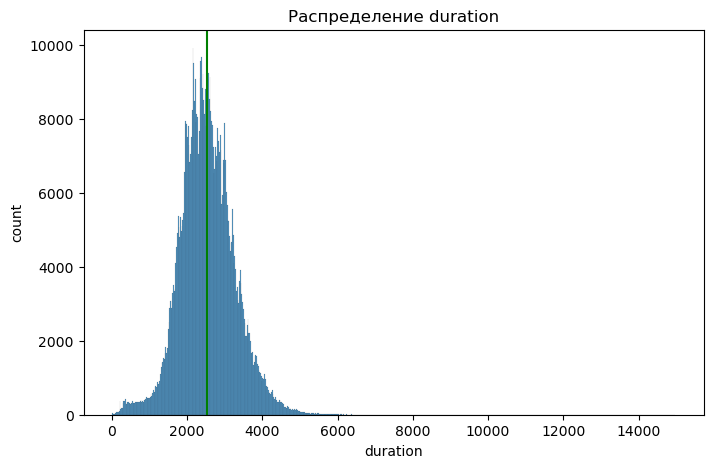

In [ ]:
#Посмотрим, какая длительность была зафиксирована
plt.figure(figsize=(8,5))
sns.histplot(matches_df_train['duration'])
plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение duration')
plt.xlabel('duration')
plt.ylabel('count')
plt.show()

<font color='blue'>Видим, что распрделение достаточно сильно смещено</font>

**Анализ предложенных решений:**

1. Заполнить пропуски константным значением:
  - Среднее: Для скошенных распределений среднее сильно смещается в сторону длинного хвоста. Использование среднего подвинет нам сильно значения.
  -  Медиана: Медиана гораздо более устойчива к выбросам и скошенности (собственно мы это и видим на картинке). Она лучше всего отражает центральную тенденцию.Мне больше всего нравится этот вариант!
  -  Мода: Мода вообще здесь не подойдетб так как ей сложно оценить такой признак, как длительность

2. Предсказать значение duration при помощи простенькой линейной модели:

 - Тоже неплохо способ, который можно попробовать.

3. Добавить отсутствие значения отдельным признаком:
  - В matches_df_test duration отсутствует всегда и по одной и той же причине — матч еще не закончился. Это не добавляет информации о длительности матча, а просто отмечает принадлежность к тесту или трейну, а нам это не надо.

<font color='blue'>**Поэтому используем медиану**</font>

In [ ]:
med=matches_df_train['duration'].median()
data['duration']=data['duration'].fillna(med)

In [ ]:
data['duration'].isna().value_counts()

duration
False    767834
Name: count, dtype: int64

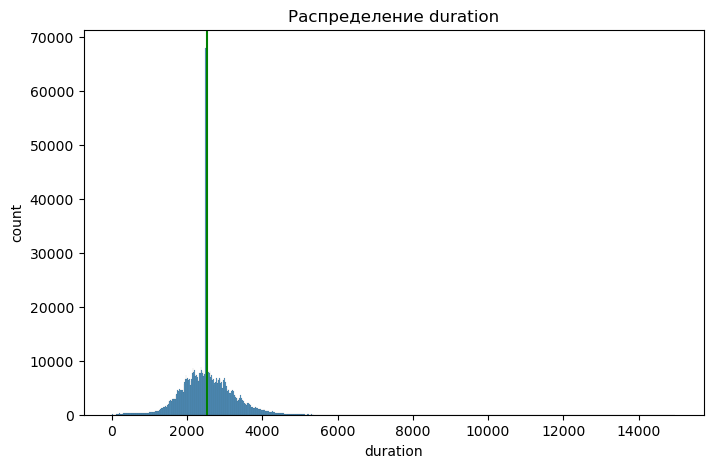

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data['duration'])
plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение duration')
plt.xlabel('duration')
plt.ylabel('count')
plt.show()

In [ ]:
test=matches_df_test.copy()
test['duration']=med

In [ ]:
X_train1=matches_df_train[['duration','game_mode']]
y_train1=matches_df_train['radiant_win']
X_test1=test[['duration','game_mode']]

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)

In [ ]:
list(set(y_pred))

[0, 1]

In [ ]:
pd.Series(y_pred).value_counts()

0    36784
1    24170
Name: count, dtype: int64

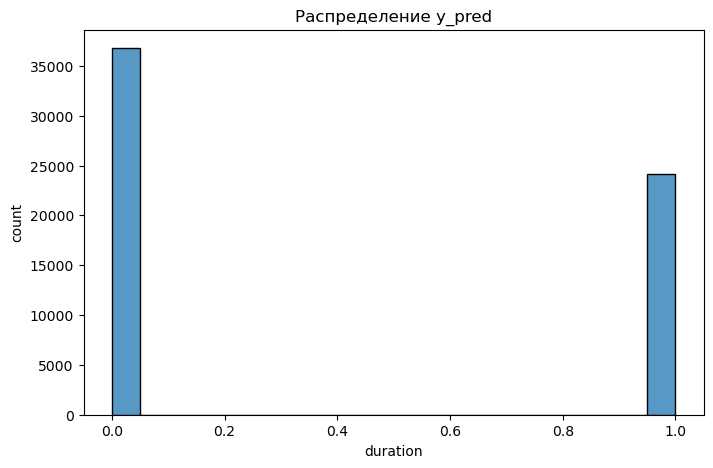

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(y_pred)
#plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение y_pred')
plt.xlabel('duration')
plt.ylabel('count')
plt.show()

<font color='blue'>**средне прогнозирует, так как на тестовых данных изначально нет ни дюрации, ни побед**</font>

In [ ]:
X_train1=matches_df_train.drop(columns=['radiant_win','date','match_id','duration'])
y_train1=matches_df_train['duration']
X_test1=test.drop(columns=['date','match_id','duration'])

In [ ]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)

In [ ]:
data1['duration']=data1['duration'].fillna(pd.Series(y_pred))

In [ ]:
data1['duration'].isna().unique()

array([False])

In [ ]:
test=data1[data['radiant_win'].isna()]
X_train1=matches_df_train[['duration','game_mode']]
y_train1=matches_df_train['radiant_win']
X_test1=test[['duration','game_mode']]

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)

In [ ]:
list(set(y_pred))

[0, 1]

In [ ]:
pd.Series(y_pred).value_counts()

0    36784
1    24170
Name: count, dtype: int64

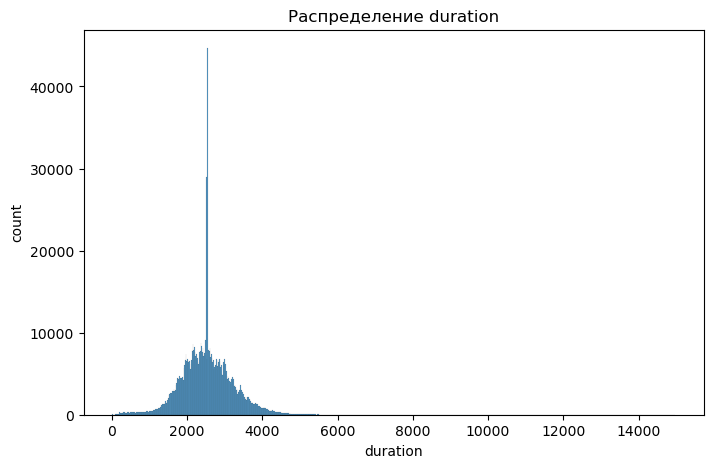

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data1['duration'])
#plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение duration')
plt.xlabel('duration')
plt.ylabel('count')
plt.show()

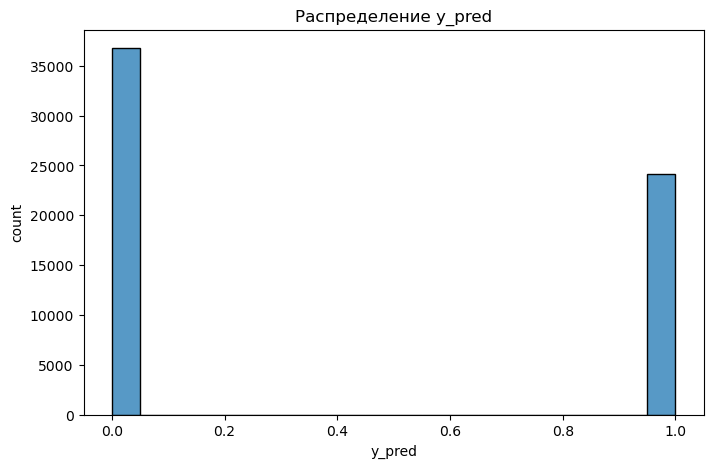

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(y_pred)
#plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение y_pred')
plt.xlabel('y_pred')
plt.ylabel('count')
plt.show()

<font color='blue'>**Можно заметить, что раницы сильно нет, но дюрация через линейную регрессию легла более равномерно, так что оставляем этот вариант**</font>

In [ ]:
data=data1.copy()

####Преобразования

В жизни рядового датасаентиста часто возникает такая ситуация, что фича, которая ну должна быть клевой, на практике оказывается тем еще отстоем. Причин тому может быть несколько: признак действительно может быть нерелевантным, в данных банально может быть ошибка; либо же мы просто неправильно этот признак готовим. Народная мудрсть (и душнилы-математики) гласит, что признаки желательно подбирать из нормального распределения в случае L2-регуляризации, тогда как на практике это достигается ой как не всегда.

Сделаем следующее:

1. Посмотрите на гистограмму признака `duration`, если вы не сделали этого до. Что вы можете сказать про смещение, среднее, хвосты распределения этого признака?
2. Изучите три распространенных способа сделать признак $y$ ($y$ здесь и ниже это `duration`, не таргет) чуть более нормальным:\
   <font color='blue'>**Уже ответила на все эти вопросы в предыдущем пункте**</font>

$$y \rightarrow \log y,  \sqrt{y}, \frac{1}{y}$$

Посмотрите, что происходит с распределением, если применить каждое из них.

3. Попробуйте добавить все три вышеперечисленных трансформации, вместе с признаком $\exp{\log{y}}$ (это снова `duration`).

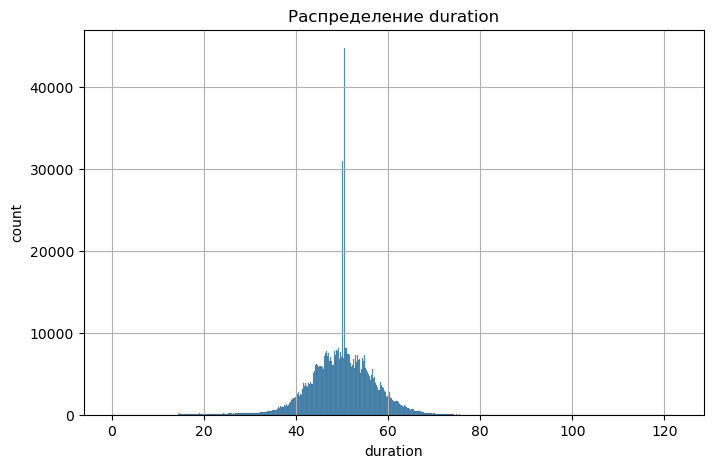

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
plt.figure(figsize=(8,5))
sns.histplot(np.sqrt(data['duration']))
#plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение duration')
plt.xlabel('duration')
plt.ylabel('count')
plt.grid(True)
plt.show()

<font color='blue'>Стало намного лучше</font>

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
plt.figure(figsize=(8,5))
sns.histplot(1/(data['duration']+1**(-10)))
#plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение duration')
plt.xlabel('duration')
plt.ylabel('count')
plt.grid(True)
plt.show()


KeyboardInterrupt



Error in callback <function flush_figures at 0x000002CD72ABCD60> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



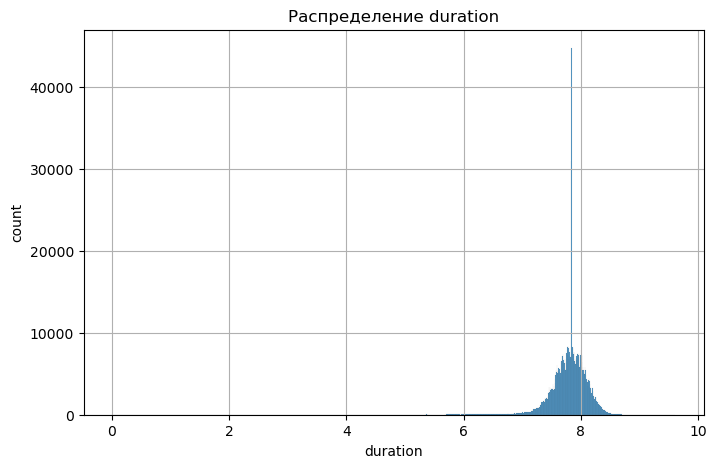

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
plt.figure(figsize=(8,5))
sns.histplot(np.log(data['duration']+1))
#plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение duration')
plt.xlabel('duration')
plt.ylabel('count')
plt.grid(True)
plt.show()

In [ ]:
data32=data['duration'].copy() #это одно и тоже с exp log data
data32['duration_log']=np.log(data['duration']+1)
data32['duration_inv']=1/(data['duration']+1**-10)
data32['duration_sqrt']=np.sqrt(data['duration'])

<font color='blue'>Оставим корень, его картинка самая подходящая</font>

In [ ]:
data['duration']=np.sqrt(data['duration'])

Обучим снова модель

In [ ]:
X1=data.loc[data['radiant_win'].isna()==False,['duration','game_mode']]
y1=data.loc[data['radiant_win'].isna()==False,['radiant_win']]

In [ ]:
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)

In [ ]:
roc_auc=roc_auc_score(y_test,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.038405537119260647

Стало лучше

#### Задание 3.3. Регионы
Не секрет, что в отдельных регионах уровень скилла игроков отличается в лучшую или худшую сторону. Даже простые, казалось бы, признаки, иногда оказываются полезными, если распределения таргета на них по какой-то причине отличаются друг от друга.

Ваша задача:

1. Построить распределение категорий признака `region` на графике.
2. Проверить, отличается ли распределение целевой переменной для разных категорий `region`.
3. Закодируйте признак

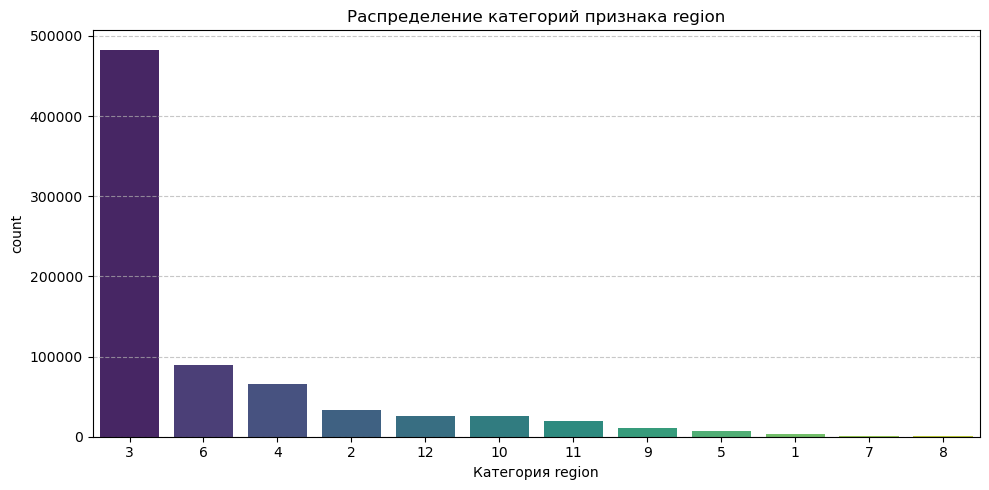

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='region', order=data['region'].value_counts().index, palette='viridis')
plt.title(f'Распределение категорий признака {'region'}')
plt.xlabel(f'Категория {'region'}')
plt.ylabel('count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

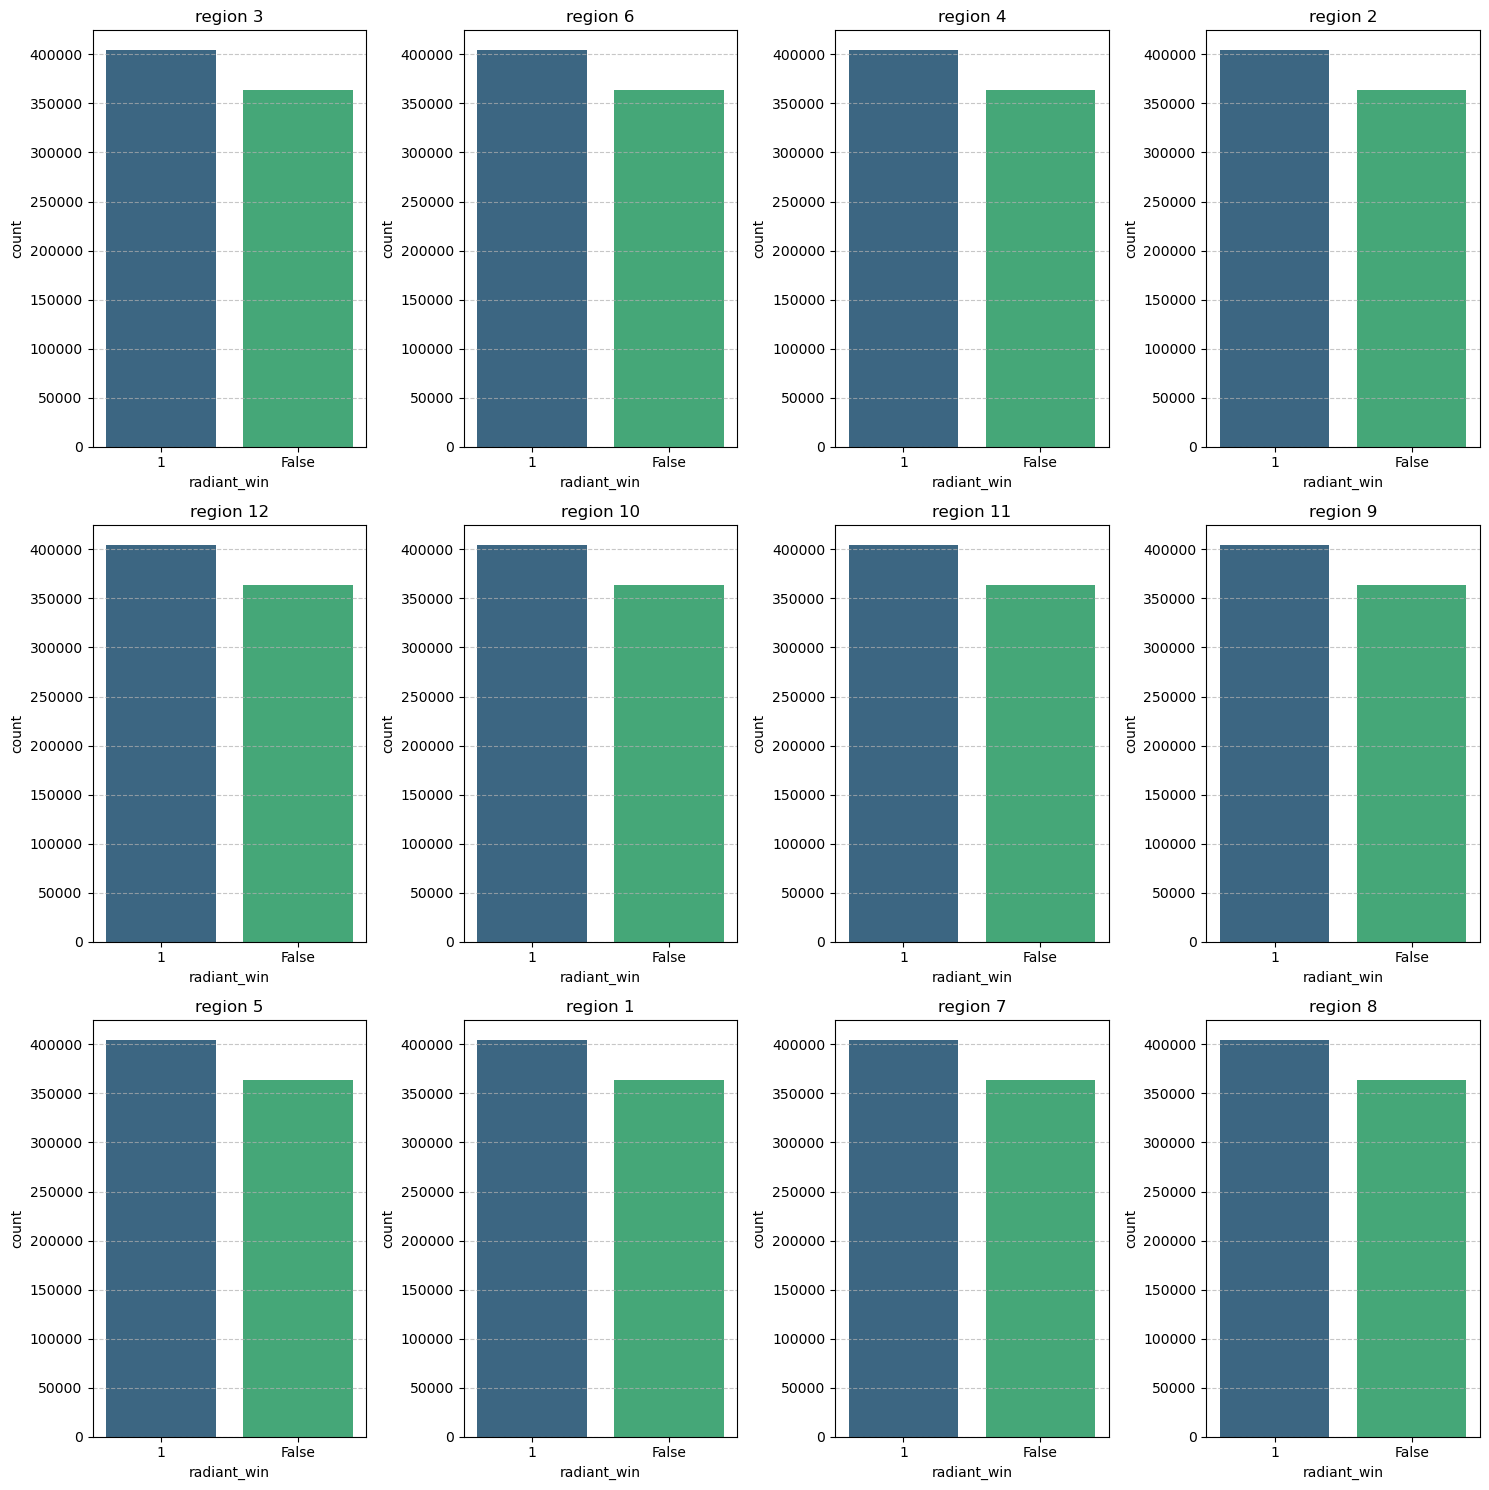

In [ ]:
import warnings
k=1
warnings.filterwarnings("ignore")
plt.figure(figsize=(15, 15))
for i in data['region'].value_counts().index:
    plt.subplot(3,4,k)
    sns.countplot(data=data, x='radiant_win', order=data.loc[data['region']==i,'radiant_win'].value_counts().index, palette='viridis')
    plt.title(f'region {i}')
    plt.xlabel('radiant_win')
    plt.ylabel('count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    k+=1
plt.show()


<font color='blue'>Видим, что распределение на разных регионах у целевой переменной очень похожее</font>

In [ ]:
import sklearn
sklearn.set_config(transform_output="pandas")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data33=data.copy()

In [ ]:
encoder_ohe = OneHotEncoder(sparse_output=False)
encoded_features = encoder_ohe.fit_transform(data33[['region']])
feature_names = encoder_ohe.get_feature_names_out(['region'])
data_ohe= pd.DataFrame(encoded_features, columns=feature_names, index=data33.index)
data_final= pd.concat([data33.drop(columns=['region',]), data_ohe], axis=1)


In [ ]:
data_final.head()

,match_id,date,game_mode,duration,radiant_win,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,region_11,region_12
0,1606558457,2024-01-01,1,7.071068,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1533104773,2024-01-01,1,9.273618,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1494396881,2024-01-01,1,14.525839,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1457581060,2024-01-01,1,16.431677,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1590242915,2024-01-01,21,17.832555,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ура

In [ ]:
data=data_final.copy()

In [ ]:
X1=data.loc[data['radiant_win'].isna()==False,['duration','game_mode','region_1','region_2','region_3','region_4','region_5','region_6','region_7','region_8','region_9','region_10','region_11','region_12']]
y1=data.loc[data['radiant_win'].isna()==False,['radiant_win']]

In [ ]:
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.038045256500900626

<font color='blue'>Джини ухудшился, скорее всего регион не очень хорошо описывает победы,нужно убрать этот признак обратно</font>

In [ ]:
data=data33.copy()

#### Задание 3.4. Даты
Бывалые игроки в доту знают, что игра постоянно (хотя это спорно) обновляется - в ней появляются новые механики, меняются старые и так далее. Разумно предположить, что со временем модель может вести себя чуточку по-другому. С временными изменениями часто помогает отслеживать изменение временных же признаков

Требуется:

1. Посмотреть, какие временные признаки можно достать, зная дату проведения матча
2. Подумать, есть ли какие-то знаменательные даты, которые могли повлиять на результаты матча (скажем, в одни дни игроки чуть более поддатые, или наоборот, в общем подумайте!)
2. Подумать, как именно вы хотите их кодировать (как числовые, категориальные, етц)
3. Вытащите хотя бы 2 разных временных признака из колонки `date`, добавьте хотя бы один флаг (признак со значением 1 или 0) для знаменательной даты

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
data33.head()

,match_id,date,region,game_mode,duration,radiant_win
0,1606558457,2024-01-01,3,1,7.071068,1.0
1,1533104773,2024-01-01,3,1,9.273618,1.0
2,1494396881,2024-01-01,3,1,14.525839,1.0
3,1457581060,2024-01-01,3,1,16.431677,1.0
4,1590242915,2024-01-01,3,21,17.832555,1.0


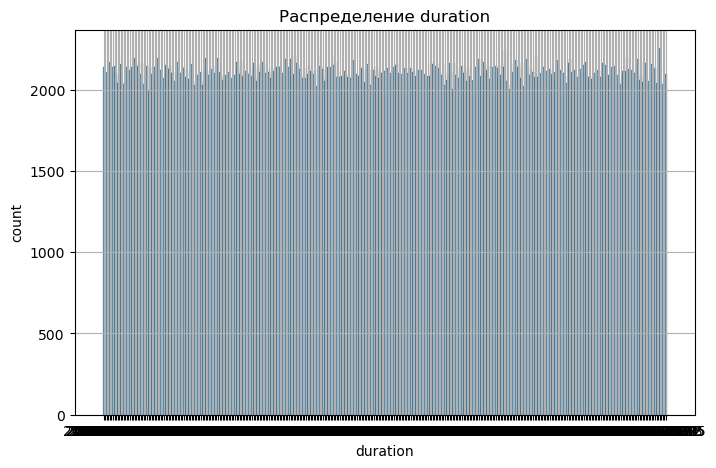

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data['date'])
#plt.axvline(mean_val, color='green', linestyle='solid', linewidth=1.5, label='Mean')
plt.title('Распределение duration')
plt.xlabel('duration')
plt.ylabel('count')
plt.grid(True)
plt.show()

In [ ]:
from datetime import datetime

In [ ]:
data33['date']=pd.to_datetime(data33['date'])

In [ ]:
data33['date'].info

<bound method Series.info of 0       2024-01-01
1       2024-01-01
2       2024-01-01
3       2024-01-01
4       2024-01-01
           ...    
60949   2024-12-08
60950   2024-12-12
60951   2024-12-03
60952   2024-12-10
60953   2024-12-25
Name: date, Length: 767834, dtype: datetime64[ns]>

<font color='blue'>Какие признаки я выделила и почему</font>

In [ ]:
data33['month'] = data33['date'].dt.month #год везде одинаковый, а дни это слишком узкий интервал для анализы, поэтому меяц это идеальная середина
data33['numofweek'] = data33['date'].dt.dayofweek #день недели, можно отследить в какие дни активность больше, в какие дни больше побед
data33['is_weekend'] = data33['date'].dt.dayofweek.isin([5, 6]).astype(int) #выходной ли это день, это логично, что в выходной скорее всего будет больше игр, эту переменную можно сделать как флаг (0-раблчий день, 1-выходной)

In [ ]:
data33['numofweek'].value_counts()

numofweek
0    112029
2    109616
1    109602
5    109326
6    109169
4    109146
3    108946
Name: count, dtype: int64

In [ ]:
data33['date'].dt.year.unique()#не буду добавлять этот столбец, если там только 2024 год

array([2024])

In [ ]:
data33['month'].value_counts()

month
5     65827
8     65339
10    65307
1     65271
7     65106
3     64982
4     63478
9     63232
12    62985
11    62748
6     62642
2     60917
Name: count, dtype: int64

<font color='blue'>Можем заметить, что данные распределены равномерно</font>

In [ ]:
data33['is_weekend'].value_counts()

is_weekend
0    549339
1    218495
Name: count, dtype: int64

<font color='blue'>Перейдем к визуализации</font>

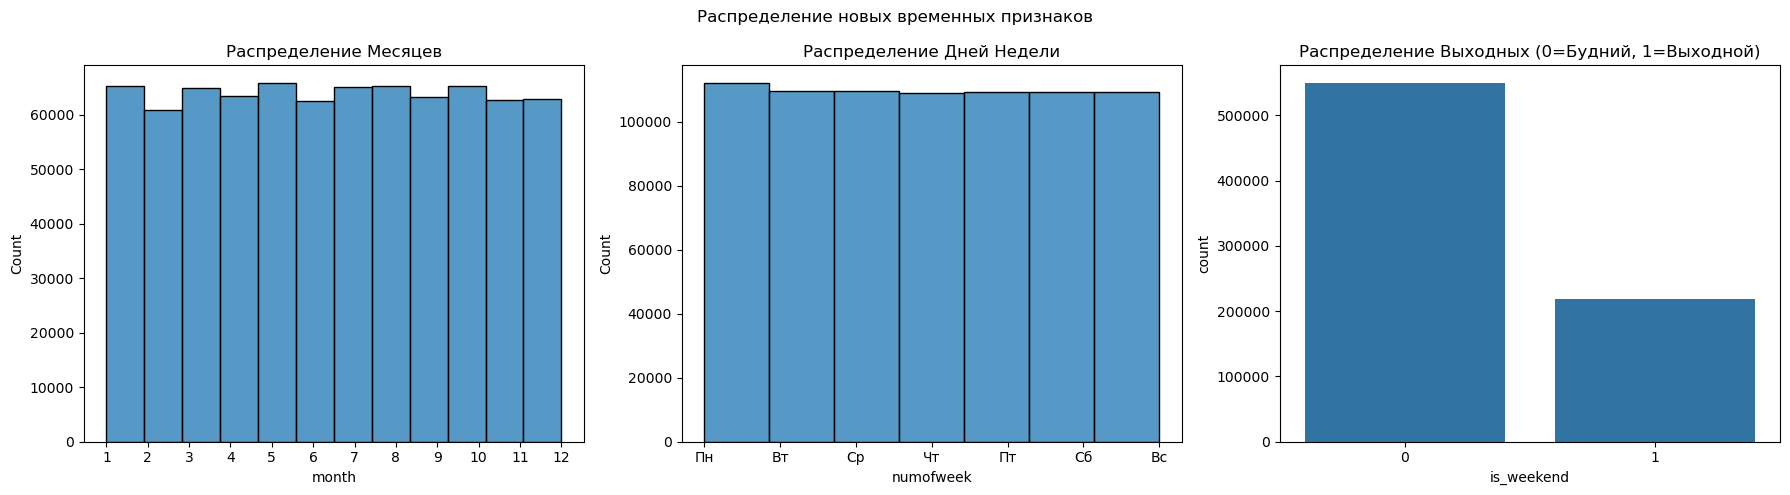

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Распределение новых временных признаков')

sns.histplot(data33['month'], bins=12, kde=False, ax=axes[0])
axes[0].set_title('Распределение Месяцев')
axes[0].set_xticks(range(1, 13))

sns.histplot(data33['numofweek'], bins=7, kde=False, ax=axes[1])
axes[1].set_title('Распределение Дней Недели')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

sns.countplot(x='is_weekend', data=data33, ax=axes[2])
axes[2].set_title('Распределение Выходных (0=Будний, 1=Выходной)')

plt.tight_layout()
plt.show()

<font color='blue'>Добавим эти признаки в нашу модель и попробуем обучить</font>

In [ ]:
data34=data.copy()#на случай,если получится фигня
data=data33.copy()

In [ ]:
X1=data.loc[data['radiant_win'].isna()==False,['duration','game_mode','month','numofweek','is_weekend']]
y1=data.loc[data['radiant_win'].isna()==False,['radiant_win']]
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(C=9.406822380190128*np.exp(-5),penalty='l2',solver='liblinear')
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.43325525888574945

<font color='blue'>Стало заметно лучше! Теперь наша модель уже лучше случайной величины)</font>

#### Задание 3.5. Бинаризация
В нашем мире бывает так, что один отдельный признак оказывается настолько важен, или настолько сложен, что одним весом в линейной регрессии его ну никак не описать. Тогда на помощь часто приходит бинаризация. Ее суть заключается в том, что все распределение признака бьется на непересекающиеся бины и каждый из них уже можно закодировать, например, отдельной категорией бина. Попробуем?

Сделайте следующее:

1. Возьмите признак, который, как вам кажется, может быть хорошей целью для бинаризации. Это может быть что угодно до тех пор, пока признак вещественный.
2. Бинаризуйте признак произвольным способом (равномерная сетка, квантильная сетка, ...).
3. Проверьте, зашло там или нет.

<font color='blue'>Возьмем duration, так как это логично, что его по бинам нааверное было было удобно смотреть</font>

In [ ]:
data35=data.copy()

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
d=np.array(data['duration'])
d = d.reshape((-1, 1))
thresholds = np.arange(np.quantile(d,0.25),np.quantile(d,0.5), np.quantile(d,0.75),np.quantile(d,1)).reshape((1, -1))

d_expand = np.hstack((
    d,
    ((d > thresholds[:, :-1]) & (d<= thresholds[:, 1:])).astype(int)))


In [ ]:
data['duration']=d_expand

In [ ]:
X1=data.loc[data['radiant_win'].isna()==False,['duration','game_mode','month','numofweek','is_weekend']]
y1=data.loc[data['radiant_win'].isna()==False,['radiant_win']]
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.43330409878902243

### Эмбеддинги

Пока что мы никак не использовали информацию про героев, а ведь от них напрямую зависит исход матча, их больше 100 штук и все они разные: кто-то сильнее, кто-то слабее. Делать мы это будем при помощи эмбеддингов. Это не самая универсальная техника, но зачастую она оказывается крайне полезной, ведь в векторном пространстве определено много веселых операций, например, поиск соседей, расстояние между векторами и прочее. Здесь мы познакомимся с самым простым способом их получения через прямое кодирование нужных категорий.

#### Задание 4.1. Эмбеддер героев (1 балл)

Посмотрите на табличку `player_df.csv`, в ней содержатся все герои, участвовавшие в матче. Ваша задача - закодировать каждый матч вектором, вида:

| match_id | match_embedding
| --- | --- |
| 228 | 1 0 0 -1 -1 0 0 |

Здесь `match_embedding` - закодированный вектор матча, каждый элемент которого принимает значение 1, если герой был в команде сил света, и -1, если в команде сил тьмы, подобно `OneHotEncoder`, но не совсем. Решение вставлять его одной колонкой или разбивать вектор на n колонок оставляем за вами.

Что хочется видеть:
1. Трансформер оформлен в виде отдельной функции или класса.
2. Трансформер принимает на вход аргумент `n_heroes`, который отвечает за то, подсчитываем мы наличие одного героя или может быть сразу нескольких, кажется ничего не мешает сразу масштабировать наше преобразование.
3. Трансформер корректно работает и корректно определяет, какой игрок из какой команды (обратите внимание на слотов игроков в матче и сообразите, как они соотносятся с командами).
4. Трансформер корректно применяется к трейну и валидации.

Детали реализации трансформера оставляем вам - можете воспользоваться [TransformerMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) и подогнать его под склерновский шаблон, можете воспользоваться готовыми трансформерами, а можете писать с нуля.

In [ ]:
class HeroesEmbedder:
    def __init__(self, n_heroes: int = 1):
        self.n_heroes = n_heroes
    def fit(self, X: pd.DataFrame, y=None):
        pass
    def transform(self, X: pd.DataFrame, y=None):
        match_embeddings = []
        for match_id, group in X.groupby('match_id'):
            embedding_vector = np.zeros(self.n_heroes, dtype=int)
            for _, row in group.iterrows():
                hero_id = row['hero_id']
                player_slot = row['player_slot']
                if 0 <= player_slot <= 4:
                    team_value = 1  # Radiant
                elif 128 <= player_slot <= 132:
                    team_value = -1 # Dire
                if hero_id<self.n_heroes:
                    embedding_vector[int(hero_id)] = team_value
            match_embeddings.append({'match_id': match_id, 'match_embedding': embedding_vector})

        return pd.DataFrame(match_embeddings)
       # raise Exception("transform method not implemented")

Как проверить корректность эмбеддера:

1) Для каждого матча горизонтальная сумма должна быть 0, то есть ровно 5 героев сил Света и 5 героев сил Тьмы. Если у вас получилось не так - не спешите ставить крест на карьере дата сайентиста, а посмотрите на эти матчи подробнее, выведите их, проанализируйте и решите, что с этим делать.
2) Для каждого матча значений '1' и '-1' должно быть ровно 5, все игроки должны иметь уникальный `id`. Опять же, если это не так - покажите, где это происходит и решите, что с этим делать.

In [ ]:
player_df.head()

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
0,130,10111871,5,3.0,8.0,15.0,2971.0,55.0,3.0,291.0,390.0,7431.0,146.0,1411590681
1,130,43341844,3,3.0,9.0,3.0,1245.0,25.0,3.0,238.0,346.0,4187.0,34.0,1388958799
2,130,72157343,53,9.0,6.0,20.0,4544.0,226.0,1.0,583.0,704.0,9406.0,2375.0,1587246664
3,1,4294967295,17,21.0,3.0,15.0,2945.0,209.0,12.0,577.0,641.0,30957.0,1801.0,1490278157
4,2,54350942,19,9.0,8.0,8.0,413.0,227.0,9.0,471.0,584.0,18215.0,627.0,1526223166


In [ ]:
embedder = HeroesEmbedder(n_heroes=112)
embedder.fit(player_df)
embeds = embedder.transform(player_df.iloc[:1000])


In [ ]:
embeds

,match_id,match_embedding
0,1188796288,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1205701820,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1207100769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1210095395,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1212409488,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
995,1635300286,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
996,1635338469,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
997,1635576372,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
998,1635745761,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Проверка на адекватность
y=player_df[player_df['hero_id']==6]
y[y['match_id']==1635300286]

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
914,0,86815295,6,7.0,11.0,5.0,2959.0,33.0,10.0,1288.0,344.0,14954.0,0.0,1635300286


<font color='blue'>Все работает, теперь можем просмотреть весь датасет</font>

<font color='blue'>Все выводится правильно, но очень долго обучается</font>

In [ ]:
embedder2 = HeroesEmbedder(n_heroes=112)
embedder2.fit(player_df)
embeds2 = embedder2.transform(player_df)

In [ ]:
embeds2.head()

,match_id,match_embedding
0,245413525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,..."
1,271145478,"[0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0..."
2,610497965,"[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0..."
3,613258812,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,639442405,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, -1, 0..."


In [ ]:
data41=matches_df_train.merge(embeds2,on='match_id',how='inner')

In [ ]:
data_orig=data.copy()
data=data41.copy()

In [ ]:
arr = pd.DataFrame(data['match_embedding'].tolist(), index=data.index)
arr.columns = [f'feature_array_{i}' for i in range(arr.shape[1])]
data_=pd.concat([data.drop('match_embedding', axis=1), arr], axis=1)

In [ ]:
data_.head()

,match_id,date,region,game_mode,duration,radiant_win,month,numofweek,is_weekend
0,1606558457,2024-01-01,3,1,7.071068,1.0,1,0,0
1,1533104773,2024-01-01,3,1,9.273618,1.0,1,0,0
2,1494396881,2024-01-01,3,1,14.525839,1.0,1,0,0
3,1457581060,2024-01-01,3,1,16.431677,1.0,1,0,0
4,1590242915,2024-01-01,3,21,17.832555,1.0,1,0,0


In [ ]:
q=data_
data_=data_.drop(columns=['duration','radiant_win','date','region','game_mode'])

In [ ]:
data_1=data_.merge(data, on='match_id',how='left')

In [ ]:
X1=data_1.loc[data_1['radiant_win'].isna()==False].drop(columns=['date','match_id','region','radiant_win'])
y1=data_1.loc[data_1['radiant_win'].isna()==False,['radiant_win']]
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test1,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.4302543897363833

In [ ]:
accuracy_raw = accuracy_score(y_test1, y_pred)
print(accuracy_raw)

0.7150549802900847


Еще одна народная мудрость, которая часто встречается в мире машинного обучения: чем лучше получается декомпозировать тот или иной признак, тем лучше. Фактически шанс на победу определенного героя, или пары-тройки-четверки героев, определяется не только тем, как часто они побеждают, но их как часто их берут, подумайте почему (необязательно вслух).

Давайте сделаем такой трансформер:

| match_id | wincount_embedding | pickcount_embedding |
| --- | --- | --- |
| 228 | 1 0 0 0 1 0 0 | 1 0 0 0 1 0 0 |
| 322 | 0.5 0 0 0 1 0 0 | 2 0 0 0 2 0 0 |
| 1337| 0.33 0 0 1 0.5 0 0 | 3 0 0 1 3 0 0 |
| ... | ... | ... |

1. Трансформер оформлен в виде класса или функции.
2. Трансформер подсчитывает **кумулятивное** число побед (`wincount_HERO`) и кумулятивное число матчей (`pickcount_HERO`) для каждого героя на тренировочной выборке и средний винрейт, средний пикрейт по герою на валидационной выборке (средние будем собирать в методе `fit`).
3. Если героя в матче нет, его винрейт не интересен, поэтому элементы эмбеддинга там будут 0.
4. Трансформер все еще может работать для связок героев, поэтому параметр `n_heroes` оставялем нетронутым.

In [ ]:
player_df1=player_df.merge(matches_df_train[['match_id','radiant_win','date']], on='match_id',how='left')

In [ ]:
player_df1['radiant_win'].value_counts()

radiant_win
1.0    3610515
0.0    3432916
Name: count, dtype: int64

In [ ]:
player_df1

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id,radiant_win,date
0,130,10111871,5,3.0,8.0,15.0,2971.0,55.0,3.0,291.0,390.0,7431.0,146.0,1411590681,0.0,2024-08-09
1,130,43341844,3,3.0,9.0,3.0,1245.0,25.0,3.0,238.0,346.0,4187.0,34.0,1388958799,1.0,2024-04-24
2,130,72157343,53,9.0,6.0,20.0,4544.0,226.0,1.0,583.0,704.0,9406.0,2375.0,1587246664,0.0,2024-06-23
3,1,4294967295,17,21.0,3.0,15.0,2945.0,209.0,12.0,577.0,641.0,30957.0,1801.0,1490278157,1.0,2024-11-29
4,2,54350942,19,9.0,8.0,8.0,413.0,227.0,9.0,471.0,584.0,18215.0,627.0,1526223166,0.0,2024-11-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7650920,4,4294967295,63,16.0,9.0,10.0,467.0,152.0,5.0,494.0,619.0,24378.0,1700.0,1505604417,1.0,2024-09-07
7650921,0,4294967295,95,8.0,11.0,13.0,9.0,183.0,4.0,449.0,544.0,13792.0,4817.0,1529607093,1.0,2024-04-08
7650922,3,122912707,36,6.0,3.0,18.0,1078.0,74.0,8.0,334.0,336.0,7769.0,533.0,1586071331,1.0,2024-01-28
7650923,0,104518723,87,4.0,11.0,9.0,1017.0,18.0,4.0,219.0,218.0,4087.0,91.0,1421206390,0.0,2024-07-18


In [ ]:
class WinrateEmbedder:

    def __init__(self, n_heroes):
        self.n_heroes = n_heroes
        self.hero_stats = {}
        self.avg_winrate = 0.0

    def fit(self, X: pd.DataFrame, y=None):
        #y=X['radiant_win']
        #X_tr,X_v,y_tr,y_v=train_test_split(X,y,train_size=0.7,random_state=18)
        for match_id, group in X.sort_values(by='date').groupby('match_id'):
                for _, row in group.iterrows():
                    hero_id = row['hero_id']
                    radiant_win = row['radiant_win']
                    player_slot = row['player_slot']
                    if hero_id<self.n_heroes:
                        self.hero_stats[int(hero_id)] = {'pickcount': 0, 'wincount': 0}

                        #self.hero_stats[int(hero_id)]['pickcount'] += 1
                        #if (radiant_win == 1 and player_slot<=4) or (radiant_win == 0 and player_slot>4):
                            #self.hero_stats[int(hero_id)]['wincount'] += 1
#        total_wins = sum(stats['wincount'] for stats in self.hero_stats.values())
 #       total_picks = sum(stats['pickcount'] for stats in self.hero_stats.values())
       # self.avg_winrate = total_wins / total_picks if total_picks > 0 else 0.0
        return self
        #raise Exception("fit method not implemented")

    def transform(self, X: pd.DataFrame, y=None):
        # ヾ(⌐■_■)ノ♪ your code here
        match_embeddings = []
        a=self.hero_stats.copy()
        current_pickcounts = np.zeros(self.n_heroes)
        current_winrates = np.zeros(self.n_heroes)
        for match_id, group in X.sort_values(by='date').groupby('match_id'):
            for _, row in group.iterrows():
                hero_id = row['hero_id']
                radiant_win = row['radiant_win']
                player_slot = row['player_slot']
                if hero_id<self.n_heroes:
                    a[int(hero_id)]['pickcount'] +=1
                    if (radiant_win == 1 and player_slot<=4) or (radiant_win == 0 and player_slot>4):
                        a[int(hero_id)]['wincount'] +=1
                    current_pickcounts[int(hero_id)] =a[int(hero_id)]['pickcount']
                    pickcount =a[int(hero_id)]['pickcount']
                    wincount = a[int(hero_id)]['wincount']
                    winrate = wincount / pickcount
                    current_winrates[int(hero_id)] = winrate
            match_embeddings.append({
                'match_id': match_id,
                'pickcount_embedding': current_pickcounts,
                'wincount_embedding': current_winrates
                    })
        return pd.DataFrame(match_embeddings)
        #raise Exception("transform method not implemented")

Как проверить корректность эмбеддера:

1) `pickcount` и `wincount` для каждого героя должны быть неубывающими, если ваш датафрейм отсортирован по дате.
2) Для каждого матча ненулевых значений в обоих эмбеддингах должно быть не более 10.

In [ ]:
wr_embedder = WinrateEmbedder(n_heroes=112)
wr_embedder.fit(player_df1)
wr_embeds = wr_embedder.transform(player_df1)

In [ ]:
wr_embeds.head()

,match_id,pickcount_embedding,wincount_embedding
0,245413525,"[3615.0, 90466.0, 141729.0, 34207.0, 115382.0,...","[0.24979253112033195, 0.4363407246921495, 0.44..."
1,271145478,"[3615.0, 90466.0, 141729.0, 34207.0, 115382.0,...","[0.24979253112033195, 0.4363407246921495, 0.44..."
2,610497965,"[3615.0, 90466.0, 141729.0, 34207.0, 115382.0,...","[0.24979253112033195, 0.4363407246921495, 0.44..."
3,613258812,"[3615.0, 90466.0, 141729.0, 34207.0, 115382.0,...","[0.24979253112033195, 0.4363407246921495, 0.44..."
4,639442405,"[3615.0, 90466.0, 141729.0, 34207.0, 115382.0,...","[0.24979253112033195, 0.4363407246921495, 0.44..."


Если вы считаете, что у вас все отлично, то вам также предлагается подумать - хотим ли мы делать вектор `winrate_embedding` вместо двух отдельных? Каково бы ни было ваше решение, обучите модель и замерьте качество. <font color='blue'>Нет, мы уже ничего не хотим</font>

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
data42=matches_df_train.merge(wr_embeds,on='match_id',how='inner')
arr = pd.DataFrame(data42['wincount_embedding'].tolist(), index=data42.index)
arr.columns = [f'feature_array_{i}' for i in range(arr.shape[1])]
data_=pd.concat([data42.drop('wincount_embedding', axis=1), arr], axis=1)
q=data_
data_=data_.drop(columns=['duration','radiant_win','date','region','game_mode','pickcount_embedding'])
data_1=data_.merge(data, on='match_id',how='left')

In [ ]:
data_1.head()

,match_id,feature_array_0,feature_array_1,feature_array_2,feature_array_3,feature_array_4,feature_array_5,feature_array_6,feature_array_7,feature_array_8,...,feature_array_110,feature_array_111,date,region,game_mode,duration,radiant_win,month,numofweek,is_weekend
0,1606558457,0.249793,0.436341,0.440905,0.417283,0.492598,0.50301,0.477173,0.488981,0.46814,...,0.473876,0.38739,2024-01-01,3,1,7.071068,1.0,1,0,0
1,1533104773,0.249793,0.436341,0.440905,0.417283,0.492598,0.50301,0.477173,0.488981,0.46814,...,0.473876,0.38739,2024-01-01,3,1,9.273618,1.0,1,0,0
2,1494396881,0.249793,0.436341,0.440905,0.417283,0.492598,0.50301,0.477173,0.488981,0.46814,...,0.473876,0.38739,2024-01-01,3,1,14.525839,1.0,1,0,0
3,1457581060,0.249793,0.436341,0.440905,0.417283,0.492598,0.50301,0.477173,0.488981,0.46814,...,0.473876,0.38739,2024-01-01,3,1,16.431677,1.0,1,0,0
4,1590242915,0.249793,0.436341,0.440905,0.417283,0.492598,0.50301,0.477173,0.488981,0.46814,...,0.473876,0.38739,2024-01-01,3,21,17.832555,1.0,1,0,0


In [ ]:
X1=data_1.loc[data_1['radiant_win'].isna()==False].drop(columns=['date','match_id','region','radiant_win'])
y1=data_1.loc[data_1['radiant_win'].isna()==False,['radiant_win']]
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test1,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.43359478077875346

In [ ]:
accuracy_raw = accuracy_score(y_test1, y_pred)
print(accuracy_raw)

0.7170872706011052


<font color='blue'>Стало немного лучше, ура, победа, но это того не стоило</font>

###  Агрегации

Одна из самых эффективных и в то же время громоздких трансформаций, которые можно сделать с данными - это разного рода агрегации. В первом дз мы немножко баловались с `group_by`, теперь сделаем то же самое, но уже на стероидах. Идея здесь максимально проста - схлопнуть массив данных до одного или нескольких чисел, которые эти данные описывают. Как правило, это довольно эффективная техника, но крайне громоздкая, например, для $n$ признаков, $m$ агрегаций и $d$ размера окна агрегаций, признаков получится чуть ли не $n \cdot m \cdot d$, что немало.

#### Статистики матча

Из данных, что мы все еще не использовали, есть статистики матча. На протяжении игры каждая команда зарабатывает золото и опыт. Как правило, считается, что чем циферки больше, тем больше у команды шансов на выигрыш. Разумеется, это не гарантия, но это мы сейчас и проверим. Ниже вы можете увидеть пример графика преимущества, на который мы и будем смотреть.



Положительное значение - преимущество в пользу команды Radiant, негативное - в пользу команды Dire. Каждое значение колонки `..._adv` содержит в себе массив значений, каждый из которых представляет из себя график, или распределение, у которого есть какие-то параметры, надо бы их достать.

Сделаем вот что:
1. Посмотрите на колонки с суффиксом `_adv`.
2. Проверьте их на наличие нанов и всяких смешных краевых случаев. В первую очередь нас интересует, чтобы они не были пустыми и чтобы в них было ровно 16 значений.
3. Посчитайте простые статистики распределения, хотя бы штуки 4. Часть из них вы можете знать из курса статистики, часть вы можете найти в вашей любимой библиотеке для обработки данных.
4. Проанализируйте, насколько это может оказаться полезным, - постройте heatmap корреляции посчитанных вами признаков с целевой переменной и между собой и сделайте вывод.

In [ ]:
def empty(df):
    dfcl=df.copy()
    for i in dfcl.columns[1:]:
        dfcl[i] = dfcl[i].apply(lambda x: None if len(x)<=16 else x)
    return dfcl

In [ ]:
dota_ad.head()

,match_id,radiant_gold_adv,radiant_exp_adv
0,1340959379,[],[]
1,1377521758,[],[]
2,1457973639,[],[]
3,1629821522,[],[]
4,1529300845,[ 0 334 179 655 31 1029 1029 1029 662 ...,[ 0 147 105 -9 -651 -471 -471 -7...


In [ ]:
dota_ad=empty(dota_ad)

In [ ]:
dota_ad=dota_ad[dota_ad['radiant_gold_adv'].isna()==False]
dota_ad=dota_ad[dota_ad['radiant_exp_adv'].isna()==False]
dota_ad.head()

,match_id,radiant_gold_adv,radiant_exp_adv
4,1529300845,[ 0 334 179 655 31 1029 1029 1029 662 ...,[ 0 147 105 -9 -651 -471 -471 -7...
9,1529771794,[ 0 -602 -487 -981 -906 -470 -470 -608 -431 ...,[ 0 -62 -491 -280 -412 586 586 586 104 ...
10,1503988874,[ 0 -41 80 -369 -816 -1278 -1278 -12...,[ 0 -91 187 67 83 -324 -324 -324 23 ...
11,1529524919,[ 0 110 -1211 -1336 -1467 -2376 -2376 -25...,[ 0 -186 -1044 -1232 -1486 -2678 -2678 -28...
12,1578325086,[ 0 111 201 -16 25 -254 -254 -2...,[ 0 158 25 -147 -559 -1262 -1262 -13...


In [ ]:
def parse(s):
    return [int(x) for x in s.strip('[]').split() if x]

In [ ]:
dota_ad['radiant_gold_adv']=dota_ad['radiant_gold_adv'].apply(parse)

In [ ]:
dota_ad['radiant_exp_adv']=dota_ad['radiant_exp_adv'].apply(parse)


In [ ]:
dota_ad['mean_gold'] = dota_ad['radiant_gold_adv'].apply(np.mean)
dota_ad['mean_exp'] = dota_ad['radiant_exp_adv'].apply(np.mean)

dota_ad['var_gold'] = dota_ad['radiant_gold_adv'].apply(np.var)
dota_ad['var_exp'] = dota_ad['radiant_exp_adv'].apply(np.var)

dota_ad['max_gold'] = dota_ad['radiant_gold_adv'].apply(np.max)
dota_ad['max_exp'] = dota_ad['radiant_exp_adv'].apply(np.max)

dota_ad['min_gold'] = dota_ad['radiant_gold_adv'].apply(np.min)
dota_ad['min_exp'] = dota_ad['radiant_exp_adv'].apply(np.min)

dota_ad['iqr_gold'] = dota_ad['radiant_gold_adv'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
dota_ad['iqr_exp'] = dota_ad['radiant_exp_adv'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

dota_ad['changes_gold'] = dota_ad['radiant_gold_adv'].apply(lambda x: np.sum(np.diff(np.sign(x)) != 0))
dota_ad['changes_exp'] = dota_ad['radiant_exp_adv'].apply(lambda x: np.sum(np.diff(np.sign(x)) != 0))


In [ ]:
cory=matches_df_train.merge(dota_ad, on='match_id', how='left').fillna(0)

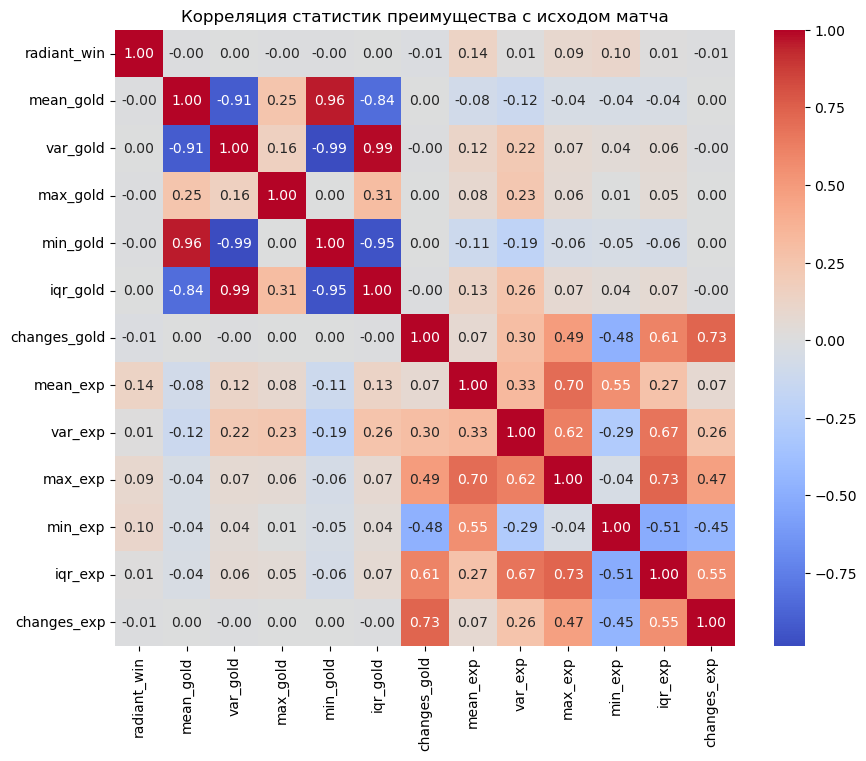

In [ ]:
cols = ['radiant_win', 'mean_gold', 'var_gold', 'max_gold', 'min_gold','iqr_gold', 'changes_gold','mean_exp','var_exp','max_exp','min_exp','iqr_exp','changes_exp']
correlation_matrix = cory[cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция статистик преимущества с исходом матча')
plt.show()

<font color='blue'>**Ничего интересного между корреляцией и признакми нет**</font>

#### Тренд

Каждый уважающий себя лудоман знает, что 99% процентов игроков останавливается ровно перед тем, как сорвать джекпот. Так и здесь - если команда с треском проигрывает в первые 15 минут матча, возможно это признак камбека в следующие 50, как знать? Попробуем собрать агрегацию похитрее - она будет обозначать тренд, который есть в графиках преимущества, и если пословица верна, наша модель уловит эту зависимость.

<span style="color:grey"><font size="1">Администрация курса МО-1 категорически осуждает азартные игры, пример приводится сугубо в образовательных целях.</font></span>

Алгоритм действий:
1. Создать трансформер, который принимает на вход функцию агрегации.
2. Выделить тренд для обоих массивов `_adv` при помощи разных функций агрегаций. Попробуйте хотя бы два разных метода: разность первого и последнего значений, линейная регрессия, обученная методом МНК, нелинейная регрессия, что-то еще...
3. Добавьте хотя бы два соответствующих признака вашим трансформером (либо два разных метода, либо тренд для Radiant и тренд для Dire).
4. Проверьте, есть ли корреляция между признаком и таргетом.

In [ ]:
def diff_trend(x): #это наша функция, которая просто будет вычитать по порядку
    if len(x) < 2:
        return 0
    return x[-1] - x[0]

def linreg_trend(x): #это уже более умная функция, с регрессией
    if len(x) < 2:
        return 0
    s, _, _, _, _ = linregress(x=np.arange(len(x)), y=x)
    return s

In [ ]:
class TrendExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, func: Callable):
        self.func=func
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        gold_trend = X['radiant_gold_adv'].apply(self.func)
        exp_trend = X['radiant_exp_adv'].apply(self.func)
        trend=pd.DataFrame({
            'gold_trend': gold_trend,
            'exp_trend': exp_trend
        })
        return trend

In [ ]:
diff=TrendExtractor(func=diff_trend)
trends=diff.transform(dota_ad)
trends.rename(columns={'gold_trend': 'gold_trend_', 'exp_trend': 'exp_trend_'}, inplace=True)

In [ ]:
lin= TrendExtractor(func=linreg_trend)
trends_ = lin.transform(dota_ad)
all_trends = pd.concat([dota_ad['match_id'], trends, trends_], axis=1)

In [ ]:
train_trends = matches_df_train.merge(all_trends, on='match_id', how='left').fillna(0)

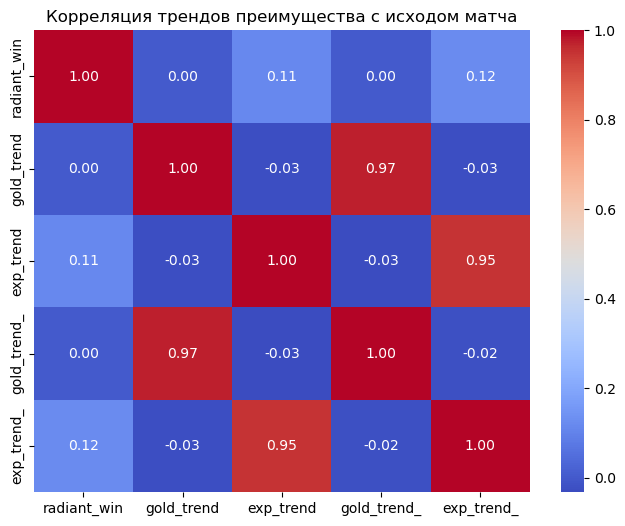

In [ ]:
corr_cols_trends =['radiant_win', 'gold_trend', 'exp_trend','gold_trend_', 'exp_trend_']
correlation_matrix_trends = train_trends[corr_cols_trends].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_trends, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция трендов преимущества с исходом матча')
plt.show()

<font color='blue'>**Ничего интересного между признакми нет, линейная связь почти отсутствует**</font>

####  Площадь под кривой и взаимодействие признаков

Скорее всего, признаки, что вы считали в предыдущих пунктах задействовали либо информацию по оси x, либо информацию по оси y, но никак не обе сразу. Один из способов попробовать учесть и то, и другое - комбинация признаков, например, можно взять и перемножить признаки между собой, либо взять и собрать кортеж из нескольких категориальных признаков. Кажется, что в пунктах с эмбеддингами и простейшим EDA это сделать совершенно не сложно, ведь признаки уже декомпозировано, а что насчет агрегаций?

Площадь под кривой, в зависимости от того, как ее считать, обладает кучей разных прикольных свойств, например, если считать ее по методу левых прямоугольников, графики, которые растут в начале, будут иметь больший скор, чем те, что растут в конце, и так далее.

Попробуем собрать трансформер поинтереснее:

1. Создать трансформер, который принимает на вход функцию интегрирования.
2. Выделить площадь для обоих массивов `_adv` при помощи двух разных функций интегрирования. Попробуйте хотя бы два разных метода: прямоугольников, трапеций, Симпсона, и т.д.
3. Добавьте хотя бы два признака (либо два метода, либо площадь для Radiant и Dire).
4. Проанализируйте самостоятельно, что важнее - преимущество в начале или в конце матча (таким образом у нас одновременно и зависимость по x, т.е. времени, и по y). Создайте кастомную функцию интегрирования (не метод прямоугольников), которая будет давать больший вест правому или левому хвосту. Добавьте этот признак.
5. Посмотрите, дает ли этот признак вклад в качество модели.

In [ ]:
from numpy import trapz as trap
from typing import Callable

In [ ]:
def trapz(x: list) -> float:
    points=x
    return trap(x)

def rectangle_area(x: list) -> float:
    return float(np.sum(x[:-1]))

In [ ]:
class AUCExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, func: Callable):
        self.func = func
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        features = pd.DataFrame(index=X.index)
        features['match_id']=X['match_id']
        for typ in ['radiant_gold_adv', 'radiant_exp_adv']:
            col=str(typ)
            rad=X[col].apply(lambda x: [max(0, val) for val in x])
            dire= X[col].apply(lambda x: [abs(min(0, val)) for val in x])
            features[str(typ)] = rad.apply(self.func)
            features[str(typ)] = dire.apply(self.func)
        return features

In [ ]:
trapz_extractor = AUCExtractor(func=trapz)
trapz_features = trapz_extractor.transform(dota_ad)
trapz_features.columns = [f'{col}_trapz' for col in trapz_features.columns]
rectangle_extractor = AUCExtractor(func=rectangle_area)
rectangle_features =rectangle_extractor.transform(dota_ad)
rectangle_features.columns = [f'{col}_rectangle_area' for col in rectangle_features.columns]

In [ ]:
rectangle_features.head()

,match_id_rectangle_area,radiant_gold_adv_rectangle_area,radiant_exp_adv_rectangle_area
4,1529300845,0.0,5550.0
9,1529771794,5386.0,1245.0
10,1503988874,21276.0,1421.0
11,1529524919,24643.0,39843.0
12,1578325086,4446.0,19974.0


In [ ]:
rectangle_features.rename(columns={'match_id_rectangle_area':'match_id'},inplace=True)

In [ ]:
trapz_features.rename(columns={'match_id_trapz':'match_id'},inplace=True)

In [ ]:
trapz_features.head()

,match_id,radiant_gold_adv_trapz,radiant_exp_adv_trapz
4,1529300845,0.0,6186.0
9,1529771794,5801.0,1245.0
10,1503988874,22976.0,1867.5
11,1529524919,24643.0,43155.0
12,1578325086,7142.0,20554.5


In [ ]:
train_trends = data[data['radiant_win'].isna()==False].merge(all_trends, on='match_id', how='left').fillna(0)

In [ ]:
train_trends_al=train_trends.merge(trapz_features, on='match_id', how='left').fillna(0)
train_trends_all=train_trends_al.merge(trapz_features, on='match_id', how='left').fillna(0)

In [ ]:
X1=train_trends_all.loc[train_trends_all['radiant_win'].isna()==False].drop(columns=['date','match_id','region','radiant_win'])
y1=train_trends_all.loc[train_trends_all['radiant_win'].isna()==False,['radiant_win']]
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test1,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.10411606761359926

###  High tech. Low life

Иногда, вместо того, чтобы думать, тратить свои когнитивные ресурсы, что-то анализировать и решать, хочется скинуть свою работу на кого-то другого, что, в целом, вполне разумно. Также и мы можем пойти по пути наименьшего сопротивления и попросить придумать фичи за нас, звучит крайне соблазнительно, а вот полезно ли - совсем другой вопрос.

#### Автогенерация признаков
В сети Интернет находится множество инструментов для автоматической генерации признаков. Как правило, они не приносят такого же значимого эффекта, как ручная генерация, посколько знания домена и области в библиотеки не запихнешь, но попробовать всегда можно.



In [ ]:
pip install featuretools


   ---------------------------------------- 0.0/587.9 kB ? eta -:--:--
   ---------------------------------------- 587.9/587.9 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 8.4 MB/s eta 0:00:00


In [ ]:
import featuretools as ft

In [ ]:
data_61=data[data['radiant_win'].isna()==False].drop_duplicates(subset=['match_id'], keep='first')

In [ ]:
dota_ad_61=dota_ad.rename(columns={'match_id':'data_match_id'})

In [ ]:
dota_ad_61['Index']= range(1, len(dota_ad_61) + 1)

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
dataframes = {
    "data_61": (data_61, "match_id",'date'),
    "dota_ad_61": (dota_ad_61, "Index"),
}


In [ ]:
relationships = [
    ("data_61", "match_id", "dota_ad_61", "data_match_id"),
]

In [ ]:
feature_matrix_data_61, features_defs = ft.dfs(
    dataframes=dataframes,
    relationships=relationships,
    target_dataframe_name="data_61",
)
feature_matrix_data_61

,region,game_mode,duration,radiant_win,month,numofweek,is_weekend,COUNT(dota_ad_61),MAX(dota_ad_61.changes_exp),MAX(dota_ad_61.changes_gold),...,SUM(dota_ad_61.mean_exp),SUM(dota_ad_61.mean_gold),SUM(dota_ad_61.min_exp),SUM(dota_ad_61.min_gold),SUM(dota_ad_61.var_exp),SUM(dota_ad_61.var_gold),DAY(date),MONTH(date),WEEKDAY(date),YEAR(date)
match_id,,,,,,,,,,,,,,,,,,,,,
668058463,6,1,24.331050,1.0,1,0,0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,2024
1191311611,5,1,37.389838,1.0,1,0,0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,2024
1195191888,3,3,55.253959,1.0,1,0,0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,2024
1195874008,9,22,39.408121,1.0,1,0,0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,2024
1196606731,3,1,43.393548,1.0,1,0,0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635972488,11,3,59.338015,1.0,12,6,1,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12,6,2024
1635990593,4,1,50.616203,1.0,12,6,1,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12,6,2024
1635991796,12,22,44.732538,1.0,12,6,1,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12,6,2024


In [ ]:
f=feature_matrix_data_61

In [ ]:
t=feature_matrix_data_61[feature_matrix_data_61.isna()==False].copy()

In [ ]:
def replace_nans_with_zero(df: pd.DataFrame) -> pd.DataFrame:
    df_processed = df.copy()
    df_processed.fillna(0, inplace=True) # inplace=True изменяет DataFrame на месте, но мы уже сделали копию
    return df_processed

In [ ]:
feature_matrix_data_61[['DAY(date)','MONTH(date)','WEEKDAY(date)','YEAR(date)']]=feature_matrix_data_61[['DAY(date)','MONTH(date)','WEEKDAY(date)','YEAR(date)']].astype('int')

In [ ]:
h=replace_nans_with_zero(feature_matrix_data_61)

In [ ]:
for i in h.columns:
    if len(h[i].unique())==1:
        h=h.drop(columns=[i])

In [ ]:
X1=h.drop(columns=['region','radiant_win','MAX(dota_ad_61.changes_exp)','MAX(dota_ad_61.changes_gold)'])
y1=h['radiant_win']
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test1,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.0

<font color='blue'>Ура никто никого никогда не заменит

#### Нейросетевые признаки

Если вы следите за новостями, то вы, наверное, заметили, что в последнее время появилась такая модная и хайповая вещь, как большие языковые модели. Злые языки утверждают, что обычному работяге фит предиктору не место в мире будущего, где господствует ИИ. Давайте в этом (раз)убедимся.

Попробуйте:
1. Спросить у вашей любимой нейросети, какие признаки она может для вас придумать. Можете опираться на пункты выше, можете придумать что-то свое. Но помните, что как говорится, какой стол, такой и стул, поэтому пишите промпты с умом.
2. Показать, что нейросеть вам посоветовала, и реализовать это
3. Проанализировать результат и сделать твердый и четкий вывод, заменят ли нас LLM-ки.

In [ ]:
# ヾ(⌐■_■)ノ♪ your code here
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from typing import Dict

In [ ]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.region_freq_map: Dict = {}
        self.game_mode_freq_map: Dict = {}
        self.region_game_mode_le: LabelEncoder = LabelEncoder()
        self.fitted_ = False

    def fit(self, X: pd.DataFrame, y=None):
        X_copy = X.copy()
        X_copy['region'] = X_copy['region'].fillna(-1).astype(int).astype(str) # -1 как 'unknown'
        X_copy['game_mode'] = X_copy['game_mode'].fillna(-1).astype(int).astype(str) # -1 как 'unknown'
        self.region_freq_map = X_copy['region'].value_counts(normalize=True).to_dict()
        self.game_mode_freq_map = X_copy['game_mode'].value_counts(normalize=True).to_dict()
        X_copy['region_game_mode_interaction_str'] = X_copy['region'].astype(str) + '_' + X_copy['game_mode'].astype(str)
        self.region_game_mode_le.fit(X_copy['region_game_mode_interaction_str'])
        self.fitted_ = True
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_transformed = X.copy()

        df_transformed['region_original'] = df_transformed['region'].copy()
        df_transformed['game_mode_original'] = df_transformed['game_mode'].copy()

        df_transformed['region'] = df_transformed['region'].fillna(-1).astype(int).astype(str)
        df_transformed['game_mode'] = df_transformed['game_mode'].fillna(-1).astype(int).astype(str)

        df_transformed['day_of_week'] = df_transformed['date'].dt.dayofweek
        df_transformed['day_of_year'] = df_transformed['date'].dt.dayofyear
        df_transformed['is_month_start'] = df_transformed['date'].dt.is_month_start.astype(int)
        df_transformed['is_month_end'] = df_transformed['date'].dt.is_month_end.astype(int)

        df_transformed['day_of_week_sin'] = np.sin(2 * np.pi * df_transformed['day_of_week'] / 7)
        df_transformed['day_of_week_cos'] = np.cos(2 * np.pi * df_transformed['day_of_week'] / 7)
        df_transformed['day_of_year_sin'] = np.sin(2 * np.pi * df_transformed['day_of_year'] / 365)
        df_transformed['day_of_year_cos'] = np.cos(2 * np.pi * df_transformed['day_of_year'] / 365)

        df_transformed['region_freq_encoded'] = df_transformed['region'].map(self.region_freq_map).fillna(0) # Заполняем 0 для неизвестных
        df_transformed['game_mode_freq_encoded'] = df_transformed['game_mode'].map(self.game_mode_freq_map).fillna(0) # Заполняем 0 для неизвестных
        interaction_str = df_transformed['region_original'].astype(str) + '_' + df_transformed['game_mode_original'].astype(str)
        def safe_transform(le, values):
            mapping = {cat: idx for idx, cat in enumerate(le.classes_)}
            return np.array([mapping.get(val, -1) for val in values])

        df_transformed['region_game_mode_encoded'] = safe_transform(self.region_game_mode_le, interaction_str)
        if df_transformed['duration'].isnull().any():
            median_duration = X['duration'].median()
            df_transformed['duration'] = df_transformed['duration'].fillna(median_duration)
        df_transformed['duration_log'] = np.log1p(df_transformed['duration'])
        df_transformed['duration_x_is_weekend'] = df_transformed['duration'] * df_transformed['is_weekend']
        df_transformed = df_transformed.drop(columns=['date', 'region', 'game_mode',
                                                      'region_original', 'game_mode_original',
                                                      'region_game_mode_interaction_str'],
                                             errors='ignore') # errors='ignore' если столбца нет

        return df_transformed


In [ ]:
gpt=FeatureGenerator()
g=gpt.fit(data)
e=g.transform(data)

In [ ]:
X1=e[e['radiant_win'].isna()==False].drop(columns=['radiant_win','match_id'])
y1=e[e['radiant_win'].isna()==False]['radiant_win']
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,stratify=y1,test_size=0.3,random_state=18)
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train1,y_train1)
y_pred=model.predict(X_test1)
roc_auc=roc_auc_score(y_test1,y_pred)
gini_valid = abs(2 * roc_auc - 1)
gini_valid

0.5699150670137529

In [ ]:
accuracy_raw = accuracy_score(y_test1, y_pred)
print(accuracy_raw)

0.7847960992907801


<font color='blue'>Нейросеть нас заменит</font>